In [1]:
#Import functions createdon my side
from Functions_custo_by_Nico import * 
Test_Imported_Functions()

import pickle

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import top_k_accuracy_score

from scipy.spatial import distance
import scipy.sparse
import implicit

from surprise import accuracy, Reader, Dataset, SVD, NormalPredictor
from surprise.model_selection import KFold, PredefinedKFold, train_test_split, cross_validate, GridSearchCV

Functions have been properly imported !


c:\Users\blanc\anaconda3\envs\IA_Project9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
src_path = os.path.abspath(os.path.join("../IA_Project9_Openclassrooms_RecommandationContenu"))
if src_path not in sys.path:
    sys.path.append(src_path)

#Build Data path
data_path = os.path.join(src_path, "dataset")
print(data_path)
for f in os.listdir(src_path):
    print("|_",f)

c:\Users\blanc\OpenClassrooms\IA_Project9_Openclassrooms_RecommandationContenu\dataset
|_ .funcignore
|_ .gitignore
|_ .venv
|_ .vscode
|_ dataset
|_ First_Serverless_API.ipynb
|_ Functions_custo_by_Nico.ipynb
|_ Functions_custo_by_Nico.py
|_ generate_CF_model-based_results.py
|_ generate_item-based_results.py
|_ host.json
|_ local.settings.json
|_ P9_01_notebook.ipynb
|_ products_get
|_ README.md
|_ requirements.txt
|_ Sources
|_ __pycache__


## Lecture et analyse des données

### Lecture des fichier nécéssaire : Train et Test et Metadata
(raccourcis à l'étape de **préparation des données** ci-dessous)

In [43]:
# Load train and test dataframes
df_clicks_metadata_train = pd.read_csv(os.path.join(data_path, "df_clicks_metadata_train.csv"))
df_clicks_metadata_test = pd.read_csv(os.path.join(data_path, "df_clicks_metadata_test.csv"))
df_clicks_metadata = pd.read_csv(os.path.join(data_path, "df_clicks_metadata.csv"))
df_metadata = pd.read_csv(os.path.join(data_path, "articles_metadata.csv"))
df_metadata["created_at_ts"] = pd.to_datetime(df_metadata["created_at_ts"],unit="ms")

### Lecture des fichiers Clicks

In [4]:
data_click_path = os.path.join(src_path, "dataset", "clicks")
clicks_files = os.listdir(data_click_path)
df_clicks_0 = pd.read_csv(os.path.join(data_click_path, clicks_files[0]))
print("le dossier clicks/ contient",len(clicks_files), "fichiers")
print("Voici un exemple du contenue du premier fichier (",clicks_files[0],")")
print("Dimensionnalité :",df_clicks_0.shape)
df_clicks_0.head()

le dossier clicks/ contient 385 fichiers
Voici un exemple du contenue du premier fichier ( clicks_hour_000.csv )
Dimensionnalité : (1883, 12)


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [5]:
df_all_clicks = pd.DataFrame()
for n in os.listdir(data_click_path):
    df_cliks_n = pd.read_csv(os.path.join(data_click_path, n))
    df_all_clicks = df_all_clicks.append(df_cliks_n)
#df_all_clicks = df_all_clicks.apply(pd.to_numeric, errors='ignore')
df_all_clicks["session_start"] = pd.to_datetime(df_all_clicks["session_start"], unit="ms")
df_all_clicks["click_timestamp"] = pd.to_datetime(df_all_clicks["click_timestamp"], unit="ms")
print("Les fichiers clicks fusionnés ont une dimensionalité de :",df_all_clicks.shape)

C:\Users\blanc\AppData\Local\Temp\ipykernel_2672\1928280345.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_clicks = df_all_clicks.append(df_cliks_n)
C:\Users\blanc\AppData\Local\Temp\ipykernel_2672\1928280345.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_clicks = df_all_clicks.append(df_cliks_n)
C:\Users\blanc\AppData\Local\Temp\ipykernel_2672\1928280345.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_clicks = df_all_clicks.append(df_cliks_n)
C:\Users\blanc\AppData\Local\Temp\ipykernel_2672\1928280345.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_clicks = df_all_clicks.append(df_cliks_n)


Les fichiers clicks fusionnés ont une dimensionalité de : (2988181, 12)


### Analyse des fichiers Clicks

In [86]:
df_all_clicks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2988181 entries, 0 to 2568
Data columns (total 12 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              object        
 1   session_id           object        
 2   session_start        datetime64[ns]
 3   session_size         object        
 4   click_article_id     object        
 5   click_timestamp      datetime64[ns]
 6   click_environment    object        
 7   click_deviceGroup    object        
 8   click_os             object        
 9   click_country        object        
 10  click_region         object        
 11  click_referrer_type  object        
dtypes: datetime64[ns](2), object(10)
memory usage: 296.4+ MB


In [87]:
df_all_clicks.describe(include='all', datetime_is_numeric=True)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181.0,2.988181e+06,2988181,2988181.0,2988181.0,2988181,2988181.0,2988181.0,2988181.0,2988181.0,2988181.0,2988181.0
unique,322897.0,1.048594e+06,NaN,72.0,46033.0,NaN,3.0,5.0,8.0,11.0,28.0,7.0
top,5890.0,1.507564e+15,NaN,2.0,160974.0,NaN,4.0,1.0,17.0,1.0,25.0,2.0
freq,1232.0,1.240000e+02,NaN,1260372.0,37213.0,NaN,2904478.0,1823162.0,1738138.0,2852406.0,804985.0,1602601.0
mean,NaN,NaN,2017-10-08 14:17:08.013157120,NaN,NaN,2017-10-08 14:51:05.606100224,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2017-10-01 02:37:03,NaN,NaN,2017-10-01 03:00:00.026000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2017-10-04 13:35:52,NaN,NaN,2017-10-04 14:20:52.854000128,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2017-10-08 20:09:00,NaN,NaN,2017-10-08 20:35:30.480999936,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2017-10-11 19:16:54,NaN,NaN,2017-10-11 19:43:24.600999936,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,2017-10-17 03:36:19,NaN,NaN,2017-11-13 20:04:14.886000,NaN,NaN,NaN,NaN,NaN,NaN


Explication des colonnes :
- **user_id** : identifiant unique d'utilisateur
- **session_id** : identifiant unique de session utilisateur. peut apparaître plusieur fois car plusieurs clic par session
- **session_start** : date (horodatage) de début de la session.
- **session_size** : Nombre de clic par session.
- **click_article_id** : article qui à était cliqué
- **click_timestamp** : date/heure du click sur l'article par l'utilisateur.
- **click_environment** : 3 valeurs non étudiées dans notre cas
- **click_deviceGroup** : 5 valeurs associée au type d'appareil utilisé (ordianeteur fixe/portable, tablette, smartphone...) 
- **click_os** : système d'exploitation de l'appareil (Android, Windows, MacOS,Linux..) 
- **click_country** : Le pays de provenance de l'utilisateur
- **click_region** : La région de l'utilisateur
- **click_referrer_type** : non étudiées dans notre cas

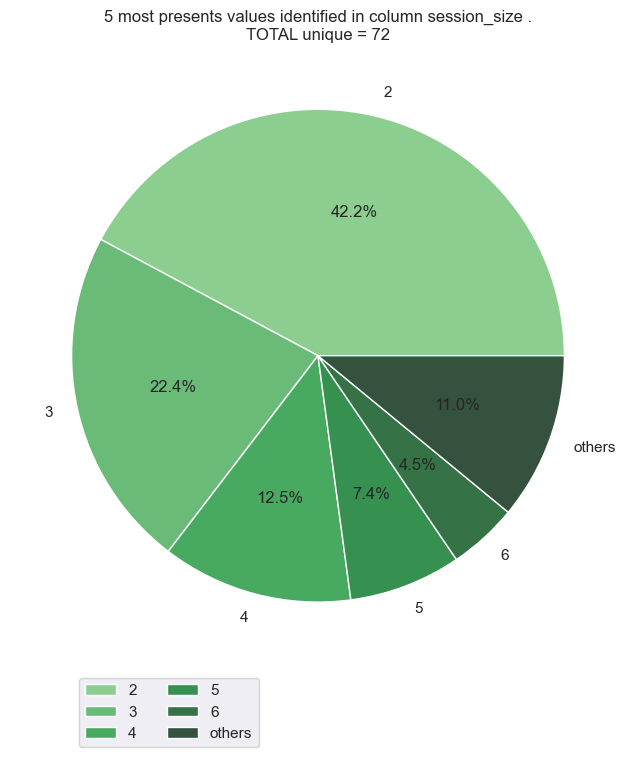

,session_size
2,1260372
3,670185
4,374240
5,220105
6,135762
others,327517


In [101]:
plot_ntops_pie(df_all_clicks, "session_size", 5, True, False)

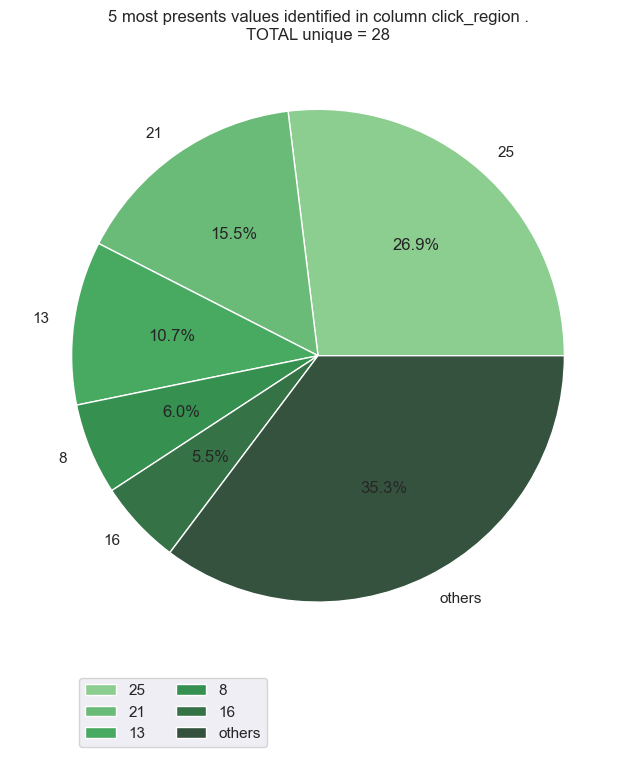

,click_region
25,804985
21,464230
13,320957
8,179339
16,164884
others,1053786


In [100]:
plot_ntops_pie(df_all_clicks, "click_region", 5, True, False)

In [78]:
print("Le click le plus ancien est :",df_all_clicks["click_timestamp"].min())
print("Le click le plus récent est :",df_all_clicks["click_timestamp"].max())

Le click le plus ancien est : 2017-10-01 03:00:00.026000
Le click le plus récent est : 2017-11-13 20:04:14.886000


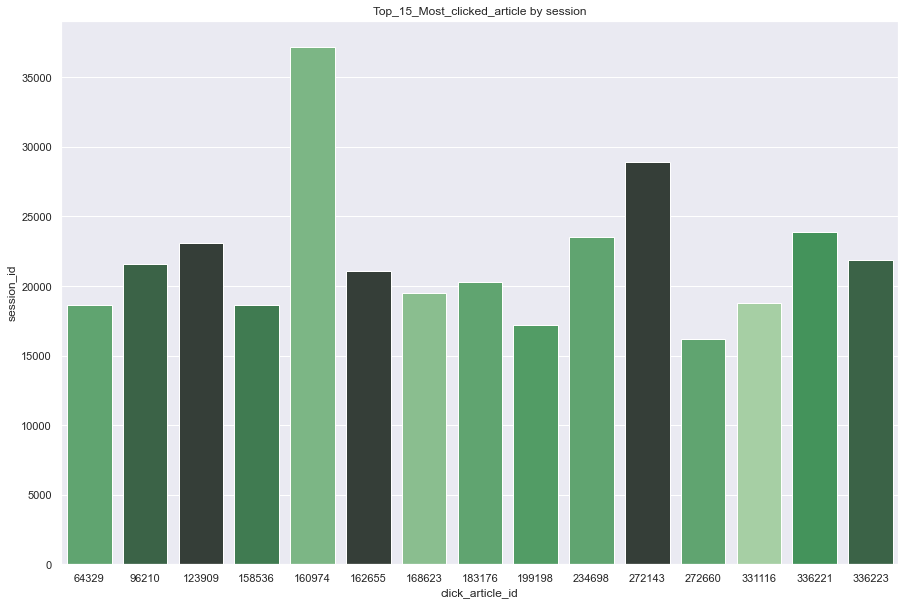

In [196]:
Top_15_Most_clicked_article_by_session = df_all_clicks.groupby("click_article_id")["session_id"].count().sort_values(ascending=False).head(15)
Top_15_Most_clicked_article_by_session = Top_15_Most_clicked_article_by_session.reset_index()

#Définir la taille du graphique
fig, ax = plt.subplots(figsize=(15,10))
#Définir le type du graphique, ici BARPLOT avec en Labels l'index du nom des libelle
ax = sns.barplot(data=Top_15_Most_clicked_article_by_session, x='click_article_id', y='session_id', palette=colors_from_values_integer(Top_15_Most_clicked_article_by_session['click_article_id'], "Greens_d"))
plt.title(f"Top_15_Most_clicked_article by session") 
#Afficher le graphique
plt.show()

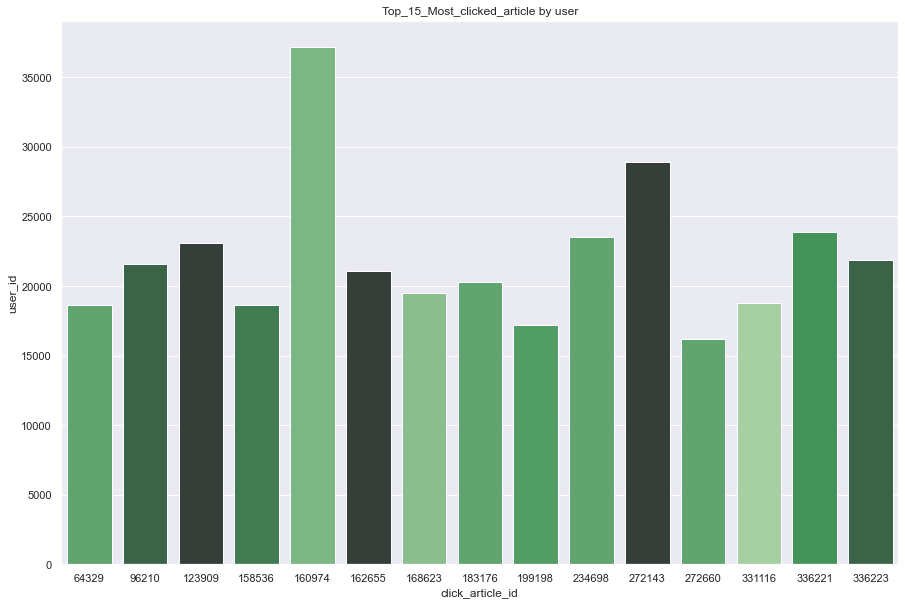

In [194]:
Top_15_Most_clicked_article_by_users = df_all_clicks.groupby("click_article_id")["user_id"].count().sort_values(ascending=False).head(15)
Top_15_Most_clicked_article_by_users = Top_15_Most_clicked_article_by_users.reset_index()

#Définir la taille du graphique
fig, ax = plt.subplots(figsize=(15,10))
#Définir le type du graphique, ici BARPLOT avec en Labels l'index du nom des libelle
ax = sns.barplot(data=Top_15_Most_clicked_article_by_users, x='click_article_id', y='user_id', palette=colors_from_values_integer(Top_15_Most_clicked_article_by_users['click_article_id'], "Greens_d"))
plt.title(f"Top_15_Most_clicked_article by user") 
#Afficher le graphique
plt.show()

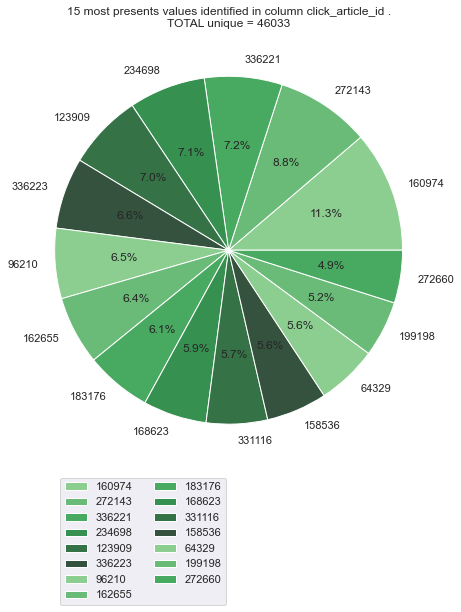

,click_article_id
160974,37213
272143,28943
336221,23851
234698,23499
123909,23122
336223,21855
96210,21577
162655,21062
183176,20303
168623,19526


In [188]:
#plot_occurence_line(df_all_clicks, "click_article_id")
plot_ntops_pie(df_all_clicks, "click_article_id", 15, False, False)

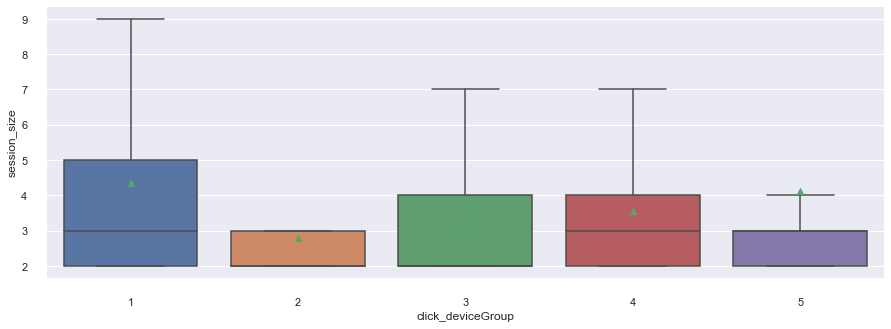

In [79]:
#plot_boxplot(df_all_clicks, "session_size", ["click_region"], True)
plot_boxplot(df_all_clicks, "click_deviceGroup", ["session_size"], False) 

In [84]:
#plot_histogramme(df_all_clicks[:500], "session_size", "click_deviceGroup", False)

### Lecture du fichier Clicks_sample

In [5]:
df_clicks_sample=pd.read_csv(os.path.join(data_path,"clicks_sample.csv"))
df_clicks_sample = df_clicks_sample.apply(pd.to_numeric, errors='ignore')
df_clicks_sample["session_start"] = pd.to_datetime(df_clicks_sample["session_start"], unit="ms")
df_clicks_sample["click_timestamp"] = pd.to_datetime(df_clicks_sample["click_timestamp"], unit="ms")
df_clicks_sample.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,20,2
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,4,3,20,1,20,2
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,4,1,17,1,16,2
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,4,1,17,1,16,2
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,4,1,17,1,24,2


### Analyse du fichier Clicks_sample

In [85]:
df_clicks_sample.describe(include='all', datetime_is_numeric=True)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,1883.000000,1.883000e+03,1883,1883.000000,1883.000000,1883,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,355.893787,1.506828e+15,2017-10-01 03:12:36.295273472,3.459904,176717.848646,2017-10-01 03:47:20.998407424,3.917153,2.305895,12.113648,1.491768,18.774827,1.764206
min,0.000000,1.506825e+15,2017-10-01 02:37:03,2.000000,2137.000000,2017-10-01 03:00:00.026000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,181.500000,1.506827e+15,2017-10-01 03:02:05.500000,2.000000,108854.000000,2017-10-01 03:11:57.964000,4.000000,1.000000,2.000000,1.000000,13.000000,1.000000
50%,353.000000,1.506828e+15,2017-10-01 03:13:32,3.000000,157541.000000,2017-10-01 03:22:43.470000128,4.000000,3.000000,17.000000,1.000000,21.000000,1.000000
75%,537.000000,1.506828e+15,2017-10-01 03:24:56,4.000000,236697.500000,2017-10-01 03:35:13.450500096,4.000000,3.000000,19.000000,1.000000,25.000000,2.000000
max,706.000000,1.506829e+15,2017-10-01 03:36:19,24.000000,363291.000000,2017-10-03 02:35:54.157000,4.000000,4.000000,20.000000,11.000000,28.000000,7.000000
std,206.162865,8.679628e+08,NaN,3.037467,82324.177259,NaN,0.410461,1.062301,7.825735,2.007772,7.083400,1.225679


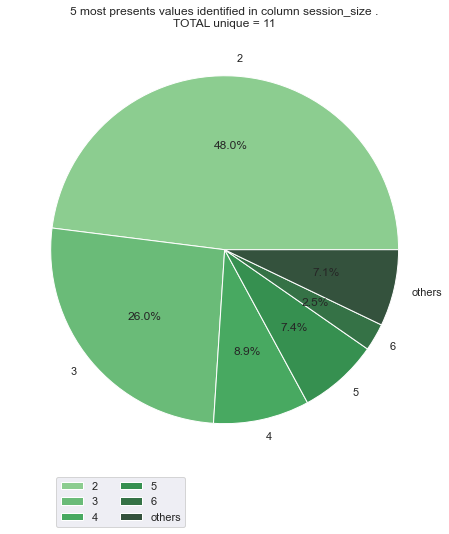

,session_size
2,904
3,489
4,168
5,140
6,48
others,134


In [189]:
plot_ntops_pie(df_clicks_sample, "session_size", 5, True, False)

### Lecture du fichier Metadata

In [6]:
df_metadata = pd.read_csv(os.path.join(data_path, "articles_metadata.csv"))
df_metadata["created_at_ts"] = pd.to_datetime(df_metadata["created_at_ts"],unit="ms")
df_metadata.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,2017-12-13 05:53:39,0,168
1,1,1,2014-07-14 12:45:36,0,189
2,2,1,2014-08-22 00:35:06,0,250
3,3,1,2014-08-19 17:11:53,0,230
4,4,1,2014-08-03 13:06:11,0,162


### Analyse du fichier Metadata

In [114]:
df_metadata.describe(include='all', datetime_is_numeric=True)

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,364047,364047.0,364047.000000
mean,182023.000000,283.108239,2016-09-16 23:57:17.328421888,0.0,190.897727
min,0.000000,0.000000,2006-09-27 11:14:35,0.0,0.000000
25%,91011.500000,199.000000,2015-10-15 16:00:43.500000,0.0,159.000000
50%,182023.000000,301.000000,2017-03-13 16:27:29,0.0,186.000000
75%,273034.500000,399.000000,2017-11-05 14:09:11,0.0,218.000000
max,364046.000000,460.000000,2018-03-13 12:12:30,0.0,6690.000000
std,105091.461061,136.723470,NaN,0.0,59.502766


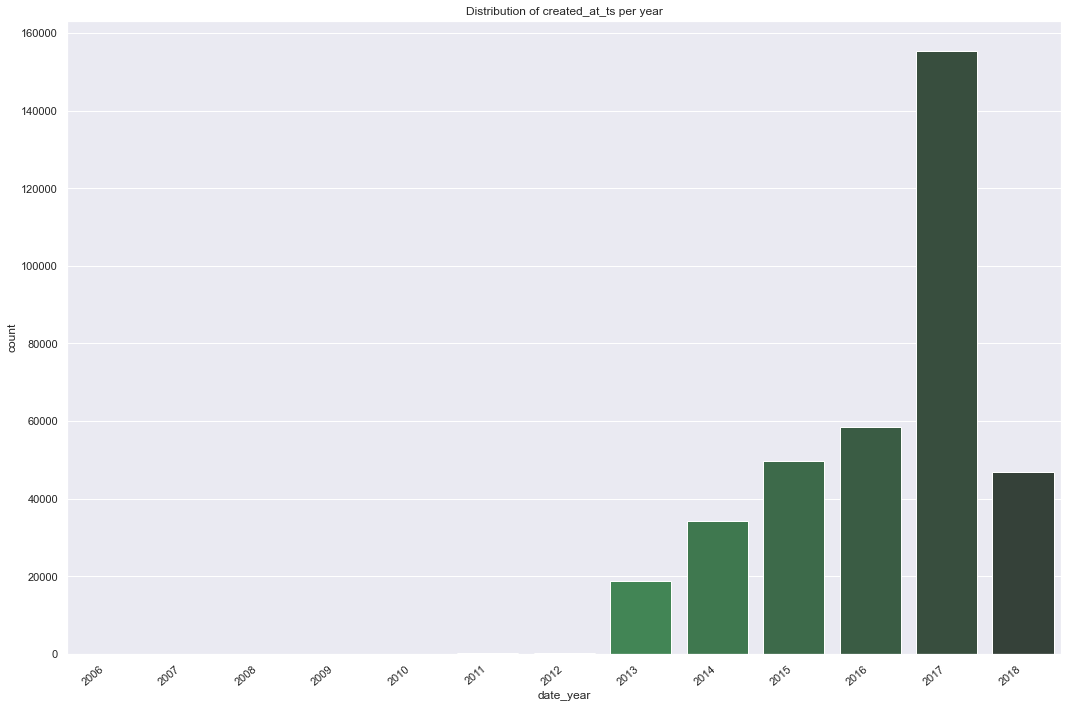

In [113]:
#plot_peryearmonth(data: pd.DataFrame, date_column, plot_hue: bool, hue_column)
#plot_peryear(data: pd.DataFrame, date_column, plot_hue: bool, hue_column)
plot_peryear(df_metadata, "created_at_ts", False, "publisher_id")

In [164]:
Top_15_Most_represented_category = df_metadata.groupby("category_id")["article_id"].count().sort_values(ascending=False).head(15)
Top_15_Most_represented_category = Top_15_Most_represented_category.reset_index()

,category_id,article_id
0,281,12817
1,375,10005
2,399,9049
3,412,8648
4,431,7759
5,428,7731
6,26,7343
7,7,6726
8,299,6634
9,301,6446


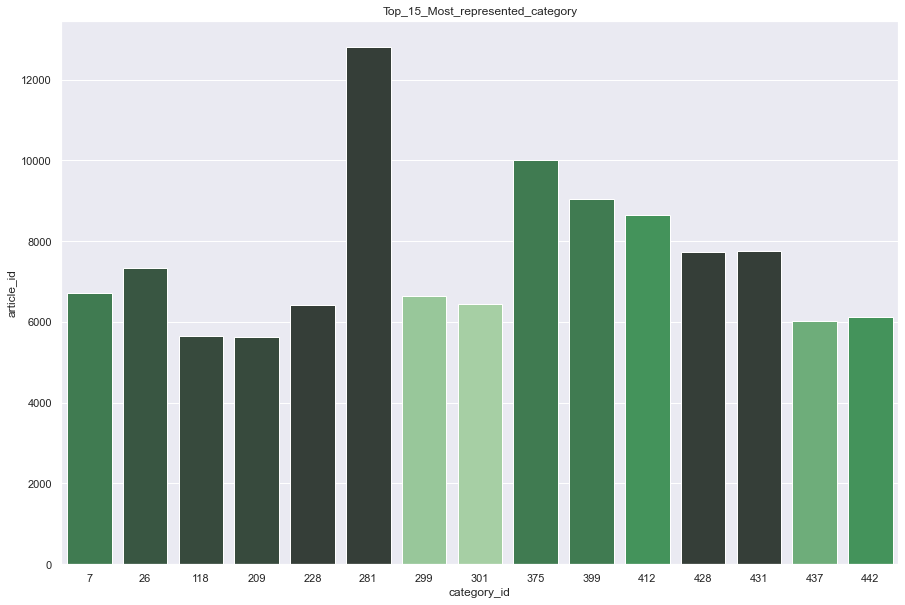

In [169]:
#Définir la taille du graphique
fig, ax = plt.subplots(figsize=(15,10))
#Définir le type du graphique, ici BARPLOT avec en Labels l'index du nom des libelle
ax = sns.barplot(data=Top_15_Most_represented_category, x='category_id', y='article_id', palette=colors_from_values_integer(Top_15_Most_represented_category['category_id'], "Greens_d"))
#ax = sns.barplot(data=Top_15_Most_represented_category, x='category_id', y='article_id', palette=colors_from_values_float(Top_15_Most_represented_category['category_id'], "Greens_d", True))
plt.title(f"Top_15_Most_represented_category") # .\nTOTAL unique = {len(df_metadata[category_id].unique())}
#Afficher le graphique
plt.show()

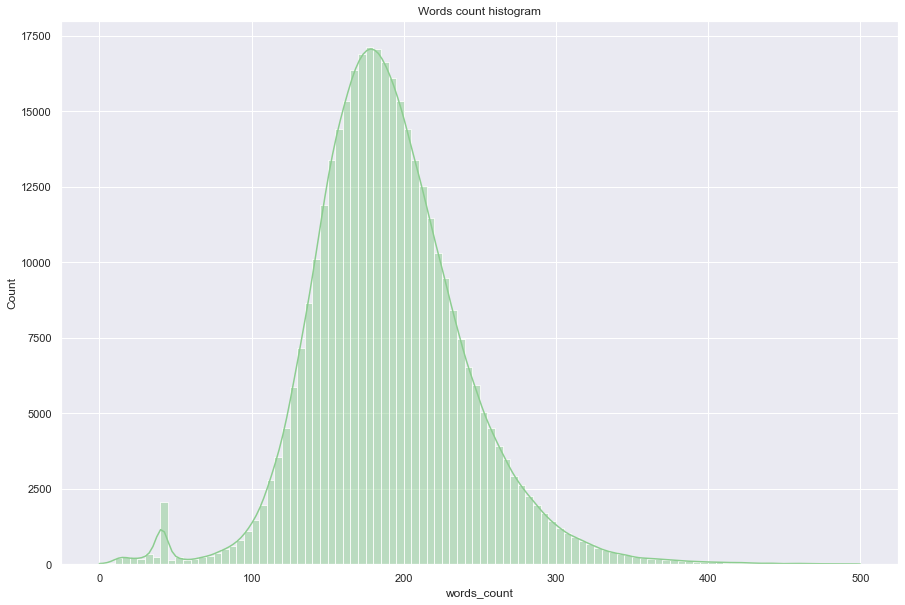

In [185]:
#Définir la taille du graphique
fig, ax = plt.subplots(figsize=(15,10))
#Définir le type du graphique, ici BARPLOT avec en Labels l'index du nom des libelle
sns.set_palette("Greens_d")
ax = sns.histplot(data=df_metadata.loc[df_metadata['words_count'] <= 500], x="words_count", bins=100, kde=True)
#sns.barplot(data=Top_15_Most_represented_category, x='category_id', y='article_id', palette=colors_from_values_integer(Top_15_Most_represented_category['category_id'], "Greens_d"))
plt.title(f"Words count histogram") # .\nTOTAL unique = {len(df_metadata[category_id].unique())}
#Afficher le graphique
plt.show()



Explication des colonnes :
- **article_id** : identifiant unique pour l'article
- **category_id** : la catégorie de l'article, il y a 461 catégories en tout.
- **created_at_ts** : date de création de l'article.
- **publisher_id** : A VERIFIER COLONNE VIDE
- **words_count** : nombre de mots dans l'article. De 0 (semble être un bug ?) à 6690.

### Lecture du fichier Pickle articles_embeddings

Il s'agit ici de lire le fichier Pickle articles_embedding.pickle, qui contient une matrice NumPy avec les vecteurs des Articles (250-dimensional vectors, et la matrice réduite à 100 dimensions ; voir T-SNE ci-dessous)

In [7]:
# open the stored data from the pickled file
articles_embeddings = open(os.path.join(data_path, "articles_embeddings.pickle"),"rb")
# dump information to that file
array_articles_embeddings = pickle.load(articles_embeddings)
# close the pickle file
articles_embeddings.close()

In [8]:
# open the stored data from the pickled file
articles_embeddings_centré_réduit = open(os.path.join(data_path, "articles_embeddings_centré_réduit.pickle"),"rb")
# dump information to that file
array_articles_embeddings_centré_réduit = pickle.load(articles_embeddings_centré_réduit)
# close the pickle file
articles_embeddings_centré_réduit.close()

array_articles_embeddings_centré_réduit.shape


(364047, 100)

### Analyse du fichier Pickle articles_embeddings

In [11]:
print("Le type de l\'objet est :",type(array_articles_embeddings))
print("Sa dimensionalité est de :",array_articles_embeddings.shape)

Le type de l'objet est : <class 'numpy.ndarray'>
Sa dimensionalité est de : (364047, 250)


In [12]:
#Affichage en 2D du plongement des articles
#Nous prenons un échantillon n du jeu de données Metadata et des Embeddings
n_sample = 20000

tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(array_articles_embeddings[:n_sample])

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["category_id"] = df_metadata["category_id"]
print(df_tsne.shape)
df_tsne.head()

c:\Users\blanc\anaconda3\envs\IA_Project9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(20000, 3)


,tsne1,tsne2,category_id
0,-5.910977,49.155399,0
1,-1.062633,-10.253881,1
2,51.944088,48.844719,1
3,36.658669,9.935280,1
4,41.455883,22.365185,1


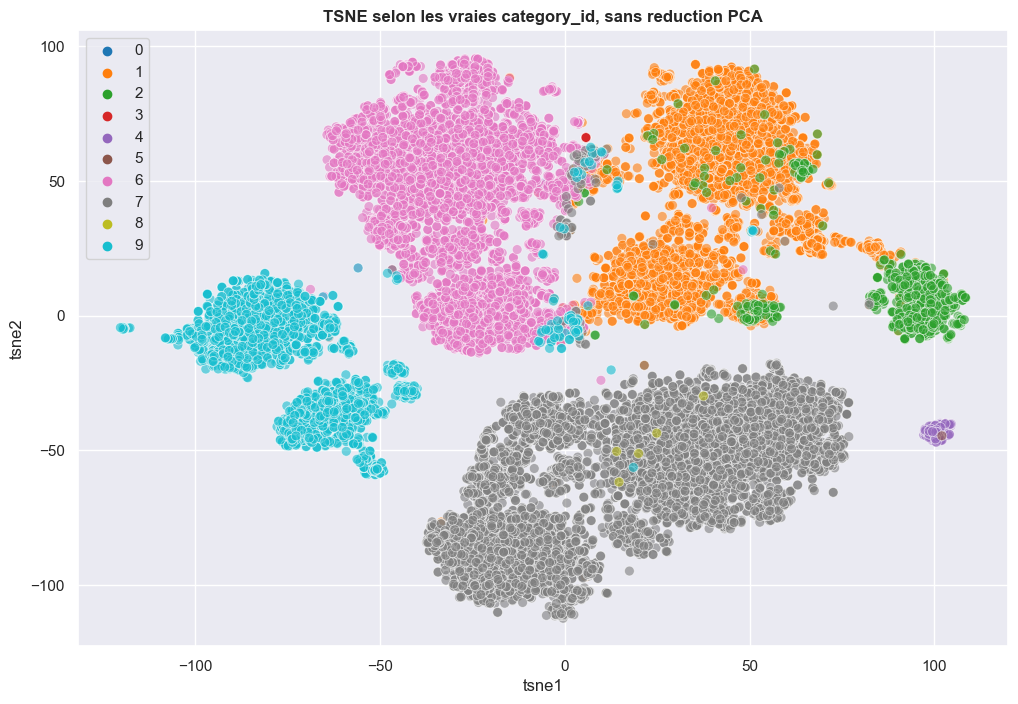

In [13]:
df_tsne["category_id"] = df_metadata["category_id"].head(n_sample)

#Définir la taille du graphique
plt.figure(figsize=(12,8))
#Définir le type du graphique,
sns.scatterplot(
    x="tsne1", y="tsne2", hue="category_id", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=df_tsne["category_id"].head(n_sample).nunique()), s=50, alpha=0.6)
#Afficher les titres et noms des axes
plt.title('TSNE selon les vraies category_id, sans reduction PCA', fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
#Afficher la légende 
plt.legend(loc='upper left')
#Afficher le graphique
plt.show()

In [14]:

# Calcul des composantes principales
print("Dimensions dataset avant réduction PCA : ", array_articles_embeddings.shape)
pca_embeddings = decomposition.PCA()
feat_pca_embeddings = pca_embeddings.fit_transform(array_articles_embeddings)
print("Dimensions dataset après réduction PCA : ", feat_pca_embeddings.shape)

#nombre de composantes calculées
n_components=pca_embeddings.n_components_
print(n_components)

#variance expliquée / eigen values
explained_variance=pca_embeddings.explained_variance_
print(sum(explained_variance)) #calcul de la somme des variance expliqués (doit être égale à n_components) 

Dimensions dataset avant réduction PCA :  (364047, 250)
Dimensions dataset après réduction PCA :  (364047, 250)
250
51.795661520861195


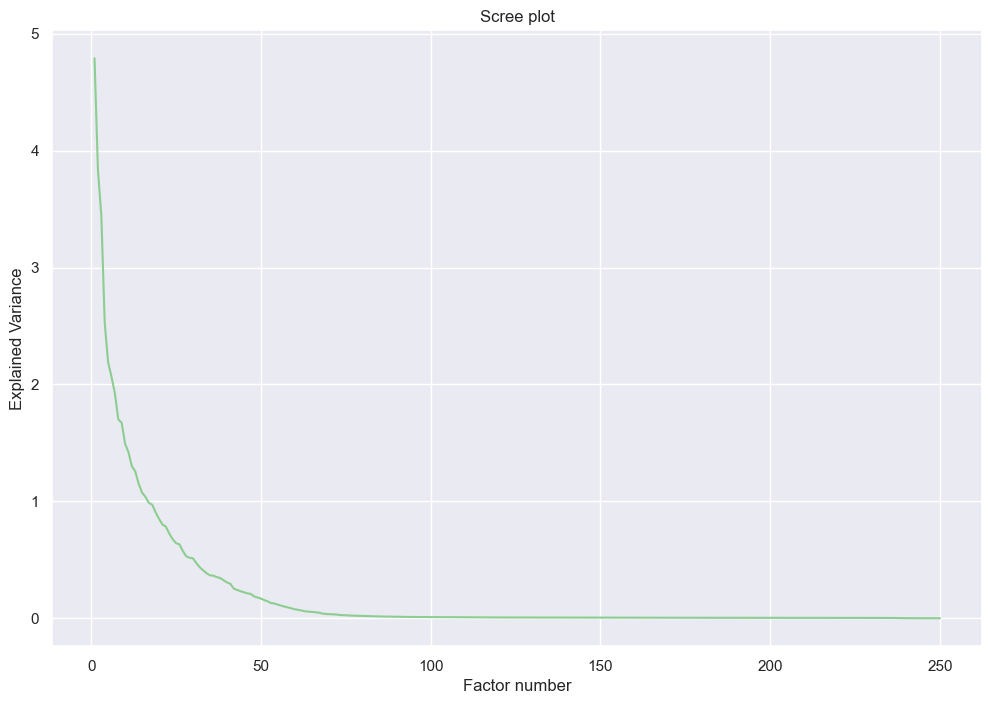

In [15]:
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#scree plot
plt.plot(np.arange(1,n_components+1),explained_variance)
plt.title("Scree plot")
plt.ylabel("Explained Variance")
plt.xlabel("Factor number")
#plt.xlim(0, 10)
plt.show()

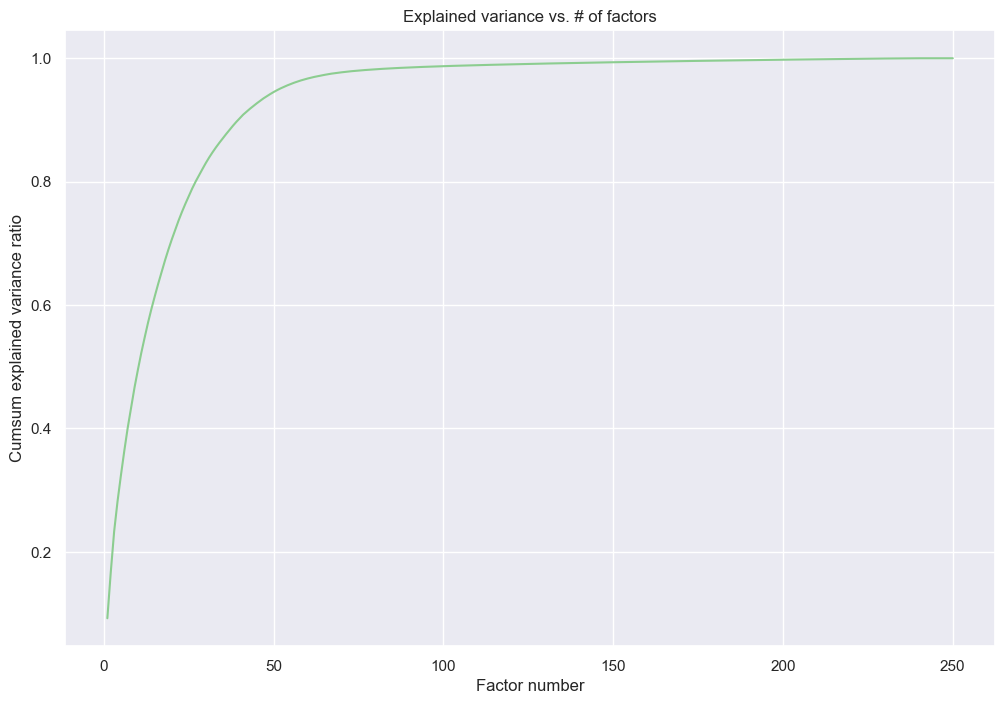

In [16]:
#proportion de variance expliquée
prop_explained_variance=pca_embeddings.explained_variance_ratio_

#Définir la taille du graphique
plt.figure(figsize=(12,8))
#cumul de variance expliquée
plt.plot(np.arange(1,n_components+1),np.cumsum(prop_explained_variance))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

In [17]:
explained_variance = pd.DataFrame(prop_explained_variance.cumsum()).iloc[100]
print(f'Explained variance after dimension reduction to 100 is = {round(explained_variance[0],4)}')

Explained variance after dimension reduction to 100 is = 0.9873


In [25]:
#Nous réalisons une normalisation sur les embeddings:
array_articles_embeddings_centré = StandardScaler().fit_transform(array_articles_embeddings) 

# Réduction en ACP des embeddings sur 100 dimensions
pca_embeddings = decomposition.PCA(100)
array_articles_embeddings_centré_réduit = pca_embeddings.fit_transform(array_articles_embeddings_centré)
# array_articles_embeddings_centré_réduit = pd.DataFrame(pca_embeddings.fit_transform(array_articles_embeddings_centré))

array_articles_embeddings_centré_réduit.shape

with open(os.path.join(data_path, "articles_embeddings_centré_réduit.pickle"),"wb") as handle:
    pickle.dump(array_articles_embeddings_centré_réduit, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [18]:
n_sample = 20000
tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(array_articles_embeddings_centré_réduit[:n_sample])

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["category_id"] = df_metadata["category_id"]
print(df_tsne.shape)
df_tsne.head()

c:\Users\blanc\anaconda3\envs\IA_Project9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(20000, 3)


,tsne1,tsne2,category_id
0,-3.310989,48.238178,0
1,-1.671796,-5.357646,1
2,55.433731,50.838688,1
3,39.105190,10.172044,1
4,42.490082,22.208187,1


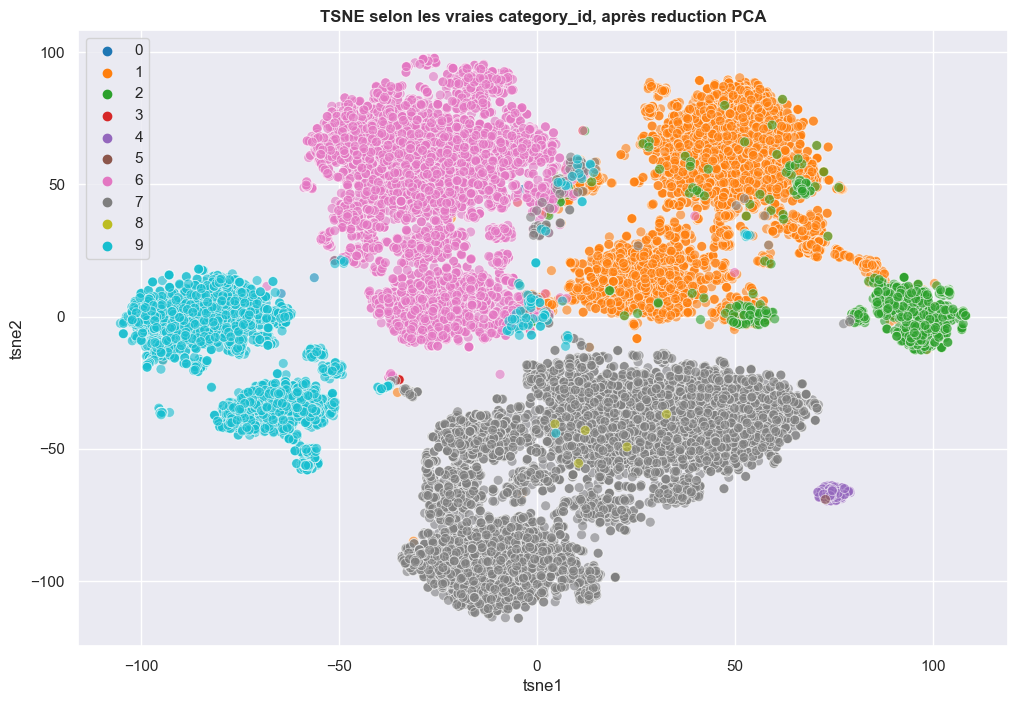

In [19]:
df_tsne["category_id"] = df_metadata["category_id"].head(n_sample)

#Définir la taille du graphique
plt.figure(figsize=(12,8))
#Définir le type du graphique,
sns.scatterplot(
    x="tsne1", y="tsne2", hue="category_id", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=df_tsne["category_id"].head(n_sample).nunique()), s=50, alpha=0.6)
#Afficher les titres et noms des axes
plt.title('TSNE selon les vraies category_id, après reduction PCA', fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
#Afficher la légende 
plt.legend(loc='upper left')
#Afficher le graphique
plt.show()

## Conclusion sur l'analyse des données

- **articles_embeddings.pickle :** 
Ce fichier contient un plongement d'article d'une dimensionnalité de 250 basé sur 364047 articles au format pickle.

- **articles_metadata.csv :**
Ce fichier contient différentes informations concernant les articles disponibles pour le consommateur

- **/clicks/ :**
Dossier avec 385 fichiers CSV, contenant les interactions des sessions d'utilisateurs dans le portail de nouvelles.

- **clicks_sample.csv :**
échantillion de fichier csv des interaction des sessions utilisateur dans le portail.

## Préparation des données

Dans un premier temps, nous allons ici fusionner les dataset **df_all_clicks** avec **df_metadata** en utilisant **article_id** comme référence commune.

Ensuite, nous allons procéder à la discretization des colonnes word_count et session_size (pour une réutilisation lors du collaborative filtering, création d'un rating)

Ensuite, nous allons supprimer les utilisateurs ayant lu moins de 3 articles.

Nous allons réitérer l'opération après suppression des articles ayant été lu moins de 15 fois.

In [9]:
# Nous mergeons les 2 dtaaframe, en utilisant la clé unique article_id
df_all_clicks_metadata = pd.merge(df_all_clicks, df_metadata, how='left',left_on=['click_article_id'],right_on=["article_id"]) #click_article_id
df_all_clicks_metadata.head(3)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,20,2,157541,281,2017-09-30 19:41:58,0,280
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,4,3,20,1,20,2,68866,136,2017-10-01 00:08:02,0,226
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,4,1,17,1,16,2,235840,375,2017-09-30 21:43:59,0,159


In [90]:
df_all_clicks_metadata.describe(include='all', datetime_is_numeric=True)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id,category_id,created_at_ts,publisher_id,words_count
count,2988181.0,2.988181e+06,2988181,2988181.0,2988181.0,2988181,2988181.0,2988181.0,2988181.0,2988181.0,2988181.0,2988181.0,2.988181e+06,2.988181e+06,2988181,2988181.0,2.988181e+06
unique,322897.0,1.048594e+06,NaN,72.0,46033.0,NaN,3.0,5.0,8.0,11.0,28.0,7.0,NaN,NaN,NaN,NaN,NaN
top,5890.0,1.507564e+15,NaN,2.0,160974.0,NaN,4.0,1.0,17.0,1.0,25.0,2.0,NaN,NaN,NaN,NaN,NaN
freq,1232.0,1.240000e+02,NaN,1260372.0,37213.0,NaN,2904478.0,1823162.0,1738138.0,2852406.0,804985.0,1602601.0,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2017-10-08 14:17:08.013157120,NaN,NaN,2017-10-08 14:51:05.606100224,NaN,NaN,NaN,NaN,NaN,NaN,1.949226e+05,3.059382e+02,2017-09-30 05:50:23.356218368,0.0,2.086283e+02
min,NaN,NaN,2017-10-01 02:37:03,NaN,NaN,2017-10-01 03:00:00.026000,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,1.000000e+00,2006-12-20 00:00:00,0.0,0.000000e+00
25%,NaN,NaN,2017-10-04 13:35:52,NaN,NaN,2017-10-04 14:20:52.854000128,NaN,NaN,NaN,NaN,NaN,NaN,1.242280e+05,2.500000e+02,2017-10-03 17:56:13,0.0,1.730000e+02
50%,NaN,NaN,2017-10-08 20:09:00,NaN,NaN,2017-10-08 20:35:30.480999936,NaN,NaN,NaN,NaN,NaN,NaN,2.023810e+05,3.270000e+02,2017-10-07 19:10:41,0.0,1.980000e+02
75%,NaN,NaN,2017-10-11 19:16:54,NaN,NaN,2017-10-11 19:43:24.600999936,NaN,NaN,NaN,NaN,NaN,NaN,2.770670e+05,4.090000e+02,2017-10-11 10:10:51,0.0,2.320000e+02
max,NaN,NaN,2017-10-17 03:36:19,NaN,NaN,2017-11-13 20:04:14.886000,NaN,NaN,NaN,NaN,NaN,NaN,3.640460e+05,4.600000e+02,2017-11-14 13:26:54,0.0,6.690000e+03


In [10]:
# Nous cherchons à identifier les valeurs abbérantes, pour ensuite attribuer des scores pertinents qui serviront à notre "Rating" lors du Collaborative Filtering
quantiles = [0, 0.001, 0.3, 0.7, 0.8, 0.9, 0.99, 0.999, 1]
columns_quantiles_study = ['quantile_value', 'words_count_quantile_value', 'words_count_number', 'session_size_quantile_value', 'session_size_count_number']
quantiles_df = pd.DataFrame(columns=columns_quantiles_study)
for i in range(len(quantiles)):
    if i == 0:
        words_count_number = df_all_clicks_metadata.words_count[(df_all_clicks_metadata.words_count <= df_all_clicks_metadata['words_count'].quantile(quantiles[i]))].count()
        session_size_count_number = df_all_clicks_metadata.session_size[(df_all_clicks_metadata.session_size <= df_all_clicks_metadata['session_size'].quantile(quantiles[i]))].count()
    else:
        words_count_number = df_all_clicks_metadata.words_count[(df_all_clicks_metadata.words_count > df_all_clicks_metadata['words_count'].quantile(quantiles[i-1])) & (df_all_clicks_metadata.words_count <= df_all_clicks_metadata['words_count'].quantile(quantiles[i]))].count()
        session_size_count_number = df_all_clicks_metadata.session_size[(df_all_clicks_metadata.session_size > df_all_clicks_metadata['session_size'].quantile(quantiles[i-1])) & (df_all_clicks_metadata.session_size <= df_all_clicks_metadata['session_size'].quantile(quantiles[i]))].count()
    quantiles_list =   [quantiles[i],
                        df_all_clicks_metadata['words_count'].quantile(quantiles[i]), 
                        words_count_number,
                        df_all_clicks_metadata['session_size'].quantile(quantiles[i]),
                        session_size_count_number
                        ]
    quantiles_serie = pd.Series(quantiles_list, index = columns_quantiles_study)
    quantiles_df = quantiles_df.append(quantiles_serie, ignore_index=True)
    #quantiles_df = pd.concat(quantiles_serie, axis=0, ignore_index=True)

C:\Users\blanc\AppData\Local\Temp\ipykernel_2672\1164203639.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantiles_df = quantiles_df.append(quantiles_serie, ignore_index=True)
C:\Users\blanc\AppData\Local\Temp\ipykernel_2672\1164203639.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantiles_df = quantiles_df.append(quantiles_serie, ignore_index=True)
C:\Users\blanc\AppData\Local\Temp\ipykernel_2672\1164203639.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantiles_df = quantiles_df.append(quantiles_serie, ignore_index=True)
C:\Users\blanc\AppData\Local\Temp\ipykernel_2672\1164203639.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

In [11]:
quantiles_df

,quantile_value,words_count_quantile_value,words_count_number,session_size_quantile_value,session_size_count_number
0,0.0,0.0,65.0,2.0,1260372.0
1,0.001,16.0,3457.0,2.0,0.0
2,0.3,180.0,911340.0,2.0,0.0
3,0.7,223.0,1188173.0,4.0,1044425.0
4,0.8,241.0,300799.0,5.0,220105.0
5,0.9,262.0,295455.0,7.0,224116.0
6,0.99,414.0,259208.0,18.0,210394.0
7,0.999,1044.0,29553.0,48.0,25844.0
8,1.0,6690.0,131.0,124.0,2925.0


In [14]:
# Discretize values from session_size, in 4 categories
df_all_clicks_metadata['session_size_discretized'] = pd.cut(df_all_clicks_metadata['session_size'], bins=[0, 1, df_all_clicks_metadata['session_size'].quantile(0.7), df_all_clicks_metadata['session_size'].quantile(0.8), df_all_clicks_metadata['session_size'].quantile(0.9), df_all_clicks_metadata['session_size'].max()], labels=False)
# Normalize  values from session_size, from 1 to 4
df_all_clicks_metadata[['session_size_normalized']] = MinMaxScaler(feature_range=(1, 4)).fit_transform(df_all_clicks_metadata[['session_size']])


In [15]:
#Verify that session_size discretized is consistent
df_all_clicks_metadata.loc[df_all_clicks_metadata['session_size_discretized'] == 3, 'session_size'].count()

224116

In [23]:
#Discrtize word_count in 2 categories: <quantile[0.001] or >quantile[0.999] = 1 ; between those two quantiles = 2
df_all_clicks_metadata['words_count_discretized'] = pd.cut(df_all_clicks_metadata['words_count'], bins=[0, df_all_clicks_metadata['words_count'].quantile(0.001), df_all_clicks_metadata['words_count'].quantile(0.9), df_all_clicks_metadata['words_count'].quantile(0.99), df_all_clicks_metadata['words_count'].max()], labels=False)
#Discrtize session_size in 2 categories: <quantile[0.999] = 1 ; >quantile[0.999] = 2
df_all_clicks_metadata['words_count_discretized'] = df_all_clicks_metadata['words_count_discretized'].fillna(1)
df_all_clicks_metadata['words_count_discretized'] = df_all_clicks_metadata['words_count_discretized'].replace(0, 1)
df_all_clicks_metadata[['words_count_normalized']] = MinMaxScaler(feature_range=(1, 3)).fit_transform(df_all_clicks_metadata[['words_count']])
df_all_clicks_metadata['words_count_discretized'].unique()

array([2., 1., 3.])

In [29]:
#Verify that session_size discretized is consistent
df_all_clicks_metadata.loc[df_all_clicks_metadata['words_count_discretized'] == 3, 'words_count'].count()

29684

In [30]:
n_article_per_user_threshold = 3
# We create a list of users that have read more than n_article_per_user_threshold
user_clicked_article_count = df_all_clicks_metadata.groupby("user_id")["click_article_id"].count()
user_whitelist = user_clicked_article_count.loc[user_clicked_article_count.values > n_article_per_user_threshold].reset_index()

# We then keep all rows for which users have read more than n_article_per_user_threshold
df_clicks_metadata = df_all_clicks_metadata.loc[df_all_clicks_metadata['user_id'].isin(user_whitelist['user_id']), :]

In [31]:
n_popularity_article_threshold = 15

for i in range(5):
    # We create a list of articles that have been read more than n_popularity_article_threshold
    clicked_article_count = df_clicks_metadata.groupby("click_article_id")["article_id"].count()
    article_whitelist = clicked_article_count.loc[clicked_article_count.values > n_popularity_article_threshold].reset_index()
    # We then keep all rows for which users have read more than n articles
    df_clicks_metadata = df_clicks_metadata.loc[df_clicks_metadata['click_article_id'].isin(article_whitelist['click_article_id']), :]

    # We create a list of users that have read more than n_article_per_user_threshold
    user_clicked_article_count = df_clicks_metadata.groupby("user_id")["click_article_id"].count()
    user_whitelist = user_clicked_article_count.loc[user_clicked_article_count.values > n_article_per_user_threshold].reset_index()
    # We then keep all rows for which users have read more than n_article_per_user_threshold
    df_clicks_metadata = df_clicks_metadata.loc[df_clicks_metadata['user_id'].isin(user_whitelist['user_id']), :]

#Save train and test dataframes
df_clicks_metadata.to_csv(os.path.join(data_path, "df_clicks_metadata.csv"))
df_clicks_metadata.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,click_referrer_type,article_id,category_id,created_at_ts,publisher_id,words_count,session_size_discretized,session_size_normalized,words_count_discretized,words_count_normalized
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,...,2,157541,281,2017-09-30 19:41:58,0,280,1,0.0,2.0,1.083707
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,4,3,20,1,...,2,68866,136,2017-10-01 00:08:02,0,226,1,0.0,1.0,1.067564
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,4,1,17,1,...,2,235840,375,2017-09-30 21:43:59,0,159,1,0.0,1.0,1.047534
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,4,1,17,1,...,2,96663,209,2017-09-30 16:13:45,0,206,1,0.0,1.0,1.061584
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,4,1,17,1,...,2,119592,247,2017-09-30 15:11:56,0,239,1,0.0,1.0,1.071450


## Séparation du dataset "Train" vs "Test"
Nous allons diviser la base de données en deux en fixant un point temporel qui séparera d'un côté le train (l'historique des articles consulté) et le test (les articles que l'on devrait recommander si la méthode était parfaite).

Rappelons que: *Le click le plus ancien est : 2017-10-01 03:00:00.026000 ; Le click le plus récent est : 2017-11-13 20:04:14.886000*

In [32]:
# Nous choisissons de séparer notre jeu de données sur une proportion 3/4 Train et 1/4 Test
max_date = df_clicks_metadata["click_timestamp"].max()
min_date = df_clicks_metadata["click_timestamp"].min()
split_date = (3*(max_date - min_date)/4) + min_date
print(f"split_date is ={split_date}")
df_clicks_metadata_train = df_clicks_metadata.loc[df_clicks_metadata['click_timestamp'] <= split_date]
print(f"df_clicks_metadata_train.shape is ={df_clicks_metadata_train.shape}")
df_clicks_metadata_test = df_clicks_metadata.loc[df_clicks_metadata['click_timestamp'] > split_date]
print(f"df_clicks_metadata_test.shape is ={df_clicks_metadata_test.shape}")

split_date is =2017-10-15 01:03:05.550500
df_clicks_metadata_train.shape is =(2365726, 21)
df_clicks_metadata_test.shape is =(255982, 21)


### Nettoyage de la base de test

Nous allons supprimer les utilisateurs présents dans la base de test, si aucune lecture n'est associé dans la base de train (sans historique, pas de recommandation)

In [33]:
# We create a list of users that have read one or more article before split_date
user_train_list = df_clicks_metadata_train["user_id"].unique
# We remove rows in test dataframe, in case users identified is not in user_train_list
df_clicks_metadata_test = df_clicks_metadata_test.loc[df_clicks_metadata_test['user_id'].isin(df_clicks_metadata_train["user_id"]), :]
print(f"df_clicks_metadata_test.shape is ={df_clicks_metadata_test.shape}")

df_clicks_metadata_test.shape is =(246199, 21)


In [34]:
#Save train and test dataframes
df_clicks_metadata_train.to_csv(os.path.join(data_path, "df_clicks_metadata_train.csv"))
df_clicks_metadata_test.to_csv(os.path.join(data_path, "df_clicks_metadata_test.csv"))


## Content-based filtering : Approche Item based

Nous recommandons un article en utilisant comme point de référence un des articles lus précédemment. 

Pour ce faire, nous utilisons la **similarité cosinus des plongements** pour calculer la ressemblance. Nous appelons aussi cela la **distance cosine** nous permettant de connaitre les articles les plus proches d'un article déjà lu par l'utilisateur.

Voir [Doc Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html#scipy-spatial-distance-cosine)
La distance cosine est définie comme suit:

$ 1 - \frac{u . v}{||u||2||v||2} $

Nous utiliserons également le "word embedding" (réduit à 100 dimensions)

In [98]:
#get all articles read by user
var= df_clicks_metadata_train.loc[df_clicks_metadata_train['user_id']==1, :]
#sort clicked articles with most recents on top
var.sort_values('click_timestamp', ascending=False).head(2)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id,category_id,created_at_ts,publisher_id,words_count,words_count_discretized,session_size_normalized
2358740,1,1507820499195442,2017-10-12 15:01:39,2,183176,2017-10-12 16:33:31.163,4,1,17,1,17,2,183176,301,2017-10-11 14:18:49,0,285,2.0,0.0
2358739,1,1507820499195442,2017-10-12 15:01:39,2,327984,2017-10-12 16:33:01.163,4,1,17,1,17,2,327984,435,2017-10-12 11:33:29,0,265,2.0,0.0


#### Recherche des Top5 articles à recommander

Nous allons itérer dans nos developpements ci-dessous, afin de trouver la meilleur formule nous permettant de prédire l'article qui sera lu.

Nous fonctionnerons ainsi, en utilisant notre base de test: *df_clicks_metadata_train*

 1. Pour un utilisateur donné (voir paramètre userId), nous retournerons les articles les plus **semblables au dernier article** qu'il a consulté:
 
   - Trouver l'ensemble des articles consulté, et relever le dernier article
   - calculer la distance cosinus 
   - Trier ces distances, en prenant les 6 plus faibles, et retourner le résultat
    

In [99]:
#Define a function that takes embeddings, user_id and clicks_metadata in arguments, and return top 5 articles proposal
# As an example, try with {user 9 ==> article 284346} or {user 24 ==> article 158094} or {user 72 ==> article 107298} (Already read by user, but recommended again)
def recommended_5_articles(array_articles_embeddings, userId, df_clicks_metadata):
    #get a list of all articles read by user
    var = df_clicks_metadata.loc[df_clicks_metadata['user_id']==userId]['click_article_id'].tolist()
    print(f"User's articles clicked in the past = {var}")
    #Take the most recent element of the list
    value = var[-1]
    print(f"User's article clicked recently = {value}")

    #get 5 articles the most similar to the selected one, using embedding weights, looking 5 indexes from 1 to 6
    distances = distance.cdist([array_articles_embeddings[value]],array_articles_embeddings, "cosine")[0]
    result = np.argsort(distances)[1:6]

    #similarity value of 5 top proposed articles (the smaller the better!)
    similarite = distance.cdist([array_articles_embeddings[value]],array_articles_embeddings[result], "cosine")[0]
    return result, similarite

#Run the function using native embeddings
result, similarite = recommended_5_articles(array_articles_embeddings, 72, df_clicks_metadata_train)
print(f"Les 5 articles recommandés sont : {result}")
print(f"La similarité entre ces 5 articles est : {similarite}")

User's articles clicked in the past = [270847, 270850, 272660, 273324, 270847, 271053, 272143, 272896, 286321, 168623, 271921, 160131, 124749, 107308, 271261, 95716, 107298]
User's article clicked recently = 107298
Les 5 articles recommandés sont : [107583 107585 106981 107298 107301]
La similarité entre ces 5 articles est : [2.22044605e-16 2.22044605e-16 2.22044605e-16 2.22044605e-16
 4.76082835e-03]


Nous nous apercevons ci-dessous, que nous ne filtrons pas les résultats. Ainsi, il est fort probable que certaines de nos propositions d'articles aient déjà été consulté.

Ci-dessous, nous identifions quelques exemples concrets (et relevons les userId qui nous interresse)

In [7]:
#Define a function that takes embeddings, user_id and clicks_metadata in arguments, and return from top 5 articles proposed, userId and article concerned by conflict
def find_5_articles_conflict(array_articles_embeddings, userId, df_clicks_metadata):
    #get a list of all articles read by user id
    var = df_clicks_metadata.loc[df_clicks_metadata['user_id']==userId]['click_article_id'].tolist()
    value = var[-1]
    distances = distance.cdist([array_articles_embeddings[value]],array_articles_embeddings, "cosine")[0]
    result = np.argsort(distances)[1:6]
    i = 0
    for i in range(0,5):
        if (result[i] in var):
            return print(f"ALERT, as recommended article has been already read by user {userId}; check article {result[i]}") 
    return
    
#Run the function using native embeddings
for userId in df_clicks_metadata_train['user_id'][:300].unique():
    find_5_articles_conflict(array_articles_embeddings, userId, df_clicks_metadata_train)


ALERT, as recommended article has been already read by user 9; check article 284346
ALERT, as recommended article has been already read by user 72; check article 107298


 2. Pour un utilisateur donné (voir paramètre userId), nous retournerons les articles les plus **semblables au dernier article** qu'il a consulté:
 
   - Trouver l'ensemble des articles consulté, et relever le dernier article
   - calculer la distance cosinus 
   - Trier ces distances, en prenant les 6 plus faibles
   - Remplacer les résultats, lorsque ceux-ci font partis des articles déjà consultés

In [102]:
#Define a function that takes embeddings, user_id and clicks_metadata in arguments, and return top 5 articles proposal, ensuring proposed article has not been read by user previously
# As an example, try with {user 9 ==> article 284346} or {user 24 ==> article 158094} or {user 72 ==> article 107298} (Already read by user, but recommended again)
def recommended_5_checked_articles(array_articles_embeddings, userId, df_clicks_metadata):
    #get a list of all articles read by user
    var = df_clicks_metadata.loc[df_clicks_metadata['user_id']==userId]['click_article_id'].tolist()
    print(f"User's articles clicked in the past = {var}")
    #Take the most recent element of the list
    value = var[-1]
    print(f"User's article clicked recently = {value}")

    #get 5 articles the most similar to the selected one, using embedding weights, looking 5 indexes from 1 to 6
    distances = distance.cdist([array_articles_embeddings[value]],array_articles_embeddings, "cosine")[0]
    result = (np.argsort(distances)[1:6])
    j = 7
    for i in range(0,5):
        if (result[i] in var):
            print(f"ALERT, as recommended article has been already read by user ; check article {result[i]}")
            # result[i] = np.argsort(distances)[j] 
            # print(f"ALERT corrected, initial recommended article has been replaced by {result[i]}")
            while ((np.argsort(distances)[j]) in var):
                j = j + 1 
            else:
                result[i] = np.argsort(distances)[j]   
                print(f"ALERT corrected, initial recommended article has been replaced by {result[i]}")
    
    #similarity value of 5 top proposed articles (the smaller the better!)
    similarite = distance.cdist([array_articles_embeddings[value]],array_articles_embeddings[result], "cosine")[0]
    return result, similarite

#Run the function using native embeddings
result, similarite = recommended_5_checked_articles(array_articles_embeddings, 9, df_clicks_metadata_train)
print(f"Les 5 articles recommandés sont : {result}")
print(f"La similarité entre ces 5 articles est : {similarite}")

User's articles clicked in the past = [284346, 285412]
User's article clicked recently = 285412
ALERT, as recommended article has been already read by user ; check article 284346
ALERT corrected, initial recommended article has been replaced by 285321
Les 5 articles recommandés sont : [284268 285706 285124 285321 284191]
La similarité entre ces 5 articles est : [0.07631968 0.08639423 0.08999977 0.10212813 0.09388805]


 3. Pour un utilisateur donné (voir paramètre userId), nous retournerons les articles les plus semblables à **l'ensemble des articles** qu'il a consulté:
 
   - Trouver l'ensemble des articles consulté, et calculer la moyenne des plongement depuis l'embedding
   - calculer la distance cosinus 
   - Trier ces distances, en prenant les 6 plus faibles
   - Remplacer les résultats, lorsque ceux-ci font partis des articles déjà consultés

In [103]:
#Define a function that takes embeddings, user_id and clicks_metadata in arguments, and return top 5 articles proposal computed from MEAN-Embedding cosine similarity, ensuring proposed article has not been read by user previously
# As an example, try with {user 9 ==> article 284346} or {user 24 ==> article 158094} or {user 72 ==> article 107298} (Already read by user, but recommended again)
def recommended_5_checked_articles_fromMeanEmbedding(array_articles_embeddings, userId, df_clicks_metadata):
    #get a list of all articles read by user
    var = df_clicks_metadata.loc[df_clicks_metadata['user_id']==userId]['click_article_id'].tolist()
    #print(f"User's articles clicked in the past = {var}")
    #Compute the Mean Embedding from all past articles
    array_past_articles_embeddings = np.zeros(shape=(len(var), (array_articles_embeddings.shape)[1]))
    for i in range(0, len(var)):
        value = var[i]
        array_past_articles_embeddings[i] = np.copy(array_articles_embeddings[value])
    array_past_articles_Mean_embeddings = np.mean(array_past_articles_embeddings, axis=0).tolist()

    #get 5 articles the most similar to the selected one, using embedding weights, looking 5 indexes from 0 to 5
    distances = distance.cdist([array_past_articles_Mean_embeddings], array_articles_embeddings, "cosine")[0]
    result = (np.argsort(distances)[0:5])
    j = 6
    for i in range(0,5):
        if (result[i] in var):
            #print(f"ALERT, as recommended article has been already read by user ; check article {result[i]}")
            while ((np.argsort(distances)[j]) in var):
                j = j + 1 
            else:
                result[i] = np.argsort(distances)[j]   
                #print(f"ALERT corrected, initial recommended article has been replaced by {result[i]}")
    
    #similarity value of 5 top proposed articles (the smaller the better!)
    similarite = distance.cdist([array_past_articles_Mean_embeddings],array_articles_embeddings[result], "cosine")[0]
    return result, similarite

#Run the function using native embeddings
result, similarite = recommended_5_checked_articles_fromMeanEmbedding(array_articles_embeddings, 24, df_clicks_metadata_train)
print(f"Les 5 articles recommandés sont : {result}")
print(f"La similarité entre ces 5 articles est : {similarite}")

Les 5 articles recommandés sont : [207419 206195 205483 208370 161270]
La similarité entre ces 5 articles est : [0.08987166 0.09576055 0.09759801 0.10425654 0.1046831 ]


In [104]:
#Run the function using reduced embeddings
result, similarite = recommended_5_checked_articles_fromMeanEmbedding(array_articles_embeddings_centré_réduit, 24, df_clicks_metadata_train)
print(f"Les 5 articles recommandés sont : {result}")
print(f"La similarité entre ces 5 articles est : {similarite}")

Les 5 articles recommandés sont : [206607 207419 207406 207482 208390]
La similarité entre ces 5 articles est : [0.09662897 0.10707919 0.10876181 0.11572836 0.1160528 ]


L'avantage de l'approche "Content Based" réside dans le fait qu'il utilise une matrice d'Embeddings (vecteurs de poids de similarité entre articles) à jour.
En revance, il ne sera pas pertinent pour tout nouvel utilisateur.

#### Mesure de la performance

Dans cette partie, nous allons mesurer la performance de notre Item-Based model.

Au regard du besoin métier, il faudra mesurer la précision du ratio d'articles proposés dans le top5, ayant été utiles à l'utilisateur.

Nous allons isoler les User_Id présent dans la base de test, et allons génerer de façon récusive l'appel à nos fonction ci-dessus:
 1. fonction *recommended_5_checked_articles* en utilisant la base de train
 2. fonction *recommended_5_checked_articles_fromMeanEmbedding* en utilisant la base de train
 Note: Nous utiliserons nos 2 embedding: 250 features natives, et réduit à 100 features

Ensuite, nous allons mesurer la performance au travers des métriques suivantes:
 - Mean Average Precision at k - mAP ([Voir Article](https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52))
 - Hit_rate: Proportion des utilisateurs pour laquelle la prédiction est pertinente ([Voir Article](https://towardsdatascience.com/ranking-evaluation-metrics-for-recommender-systems-263d0a66ef54))

In [35]:
def recommended_top5_contentbased(array_articles_embeddings, userId, df_clicks_metadata):
    #get a list of all articles read by user
    var = df_clicks_metadata.loc[df_clicks_metadata['user_id']==userId]['click_article_id'].tolist()
    #Compute the Mean Embedding from all past articles
    array_past_articles_embeddings = np.zeros(shape=(len(var), (array_articles_embeddings.shape)[1]))
    for i in range(0, len(var)):
        value = var[i]
        array_past_articles_embeddings[i] = np.copy(array_articles_embeddings[value])
    array_past_articles_Mean_embeddings = np.mean(array_past_articles_embeddings, axis=0).tolist()

    #get 5 articles the most similar to the selected one, using embedding weights, looking 5 indexes from 0 to 5
    distances = distance.cdist([array_past_articles_Mean_embeddings], array_articles_embeddings, "cosine")[0]
    result = (np.argsort(distances)[0:5])
    j = 6
    for i in range(0,5):
        if (result[i] in var):
            while ((np.argsort(distances)[j]) in var):
                j = j + 1 
            else:
                result[i] = np.argsort(distances)[j]   
    return result

def compute_metrics_map_hitcount(y_true, y_pred, k=5):
    score = 0.0
    hit_count = 0.0
    for i, p in enumerate(y_pred):
        if p in y_true and p not in y_pred[:i]:
            hit_count += 1.0
            score += hit_count / (i+1.0)
    average_precision_k = score / min(len(y_true), k)
    return average_precision_k, hit_count

In [153]:
# user_id_serie = df_clicks_metadata_test['user_id'].unique()[:1000]
# y_true_lenght_serie = []
# hit_count_serie = []

# # Boucle for sur la liste des User_Id_Test, et mesure Top_k_accuracy, en utilisant les Embbeding réduit
# for user in user_id_serie: #df_clicks_metadata_test['user_id'].unique()
#     y_pred = recommended_top5_contentbased(array_articles_embeddings_centré_réduit, user, df_clicks_metadata_train) #array_articles_embeddings_centré_réduit
#     y_true = df_clicks_metadata_test.loc[df_clicks_metadata_test['user_id'] == user, 'click_article_id'].tolist()
#     hit_count = [value for value in y_pred if value in y_true]
#     # Append user recommendantions result in list
#     hit_count_serie.append(len(hit_count))
#     y_true_lenght_serie.append(len(y_true))

# results_contentbased = pd.DataFrame(columns=['user_id', 'hit_count', 'y_true_lenght_serie'])
# results_contentbased['user_id'] = user_id_serie
# results_contentbased['hit_count'] = hit_count_serie
# results_contentbased['y_true_lenght_serie'] = y_true_lenght_serie
# results_contentbased
# #results_contentbased.to_csv(os.path.join(data_path, "results_contentbased_embedding_full.csv"))

In [154]:
array_results_contentbased = np.empty((0,6), dtype=object)
user_id_serie = df_clicks_metadata_test['user_id'].unique()[:1000]
k=5

# Boucle for sur la liste des User_Id_Test, et mesure Top_k_accuracy, en utilisant les Embbeding réduit
for user in user_id_serie: #df_clicks_metadata_test['user_id'].unique()
    y_pred = recommended_top5_contentbased(array_articles_embeddings_centré_réduit, user, df_clicks_metadata_train).tolist() #array_articles_embeddings_centré_réduit
    y_true = df_clicks_metadata_test.loc[df_clicks_metadata_test['user_id'] == user, 'click_article_id'].tolist()
    average_precision_k, hit_count = compute_metrics_map_hitcount(y_true, y_pred, k)
    # Append user recommendantions result in list
    array_results_contentbased = np.append(array_results_contentbased, np.array([[user, hit_count, average_precision_k, len(y_true), np.array(y_pred, dtype=object), np.array(y_true, dtype=object)]]), axis=0)

results_contentbased = pd.DataFrame(array_results_contentbased, columns=['user_id', 'hit_count', 'average_precision', 'y_true_lenght_serie', 'y_pred_serie', 'y_true_serie'])

Mean_Average_Precision_at_k = results_contentbased['average_precision'].mean() #np.mean([average_precision_k(y_true, y_pred, k=5) for y_true, y_pred in zip(y_true_serie, y_pred_serie)])
print(f"Mean_Average_Precision_at_k is = {Mean_Average_Precision_at_k}")
#results_contentbased.to_csv(os.path.join(data_path, "results_contentbased_embedding_reduit.csv"))
results_contentbased.sort_values('hit_count', ascending=False).head()

C:\Users\blanc\AppData\Local\Temp\ipykernel_3724\2442474380.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array_results_contentbased = np.append(array_results_contentbased, np.array([[user, hit_count, average_precision_k, len(y_true), np.array(y_pred, dtype=object), np.array(y_true, dtype=object)]]), axis=0)


,user_id,hit_count,average_precision,y_true_lenght_serie,y_pred_serie,y_true_serie
359,100099,1.0,0.2,9,"[211455, 278799, 165163, 212400, 212385]","[107302, 145264, 211455, 292390, 209236, 36162..."
360,6719,1.0,0.05,7,"[188963, 195507, 188449, 195198, 194928]","[108858, 195198, 194674, 288528, 168564, 18576..."
550,26291,1.0,0.04,21,"[202961, 202445, 207692, 202443, 202320]","[168564, 343256, 293513, 57748, 58619, 74722, ..."
667,17219,0.0,0.0,2,"[345231, 344909, 283616, 285294, 345553]","[206763, 209013]"
671,45313,0.0,0.0,14,"[206607, 206195, 205575, 207955, 202369]","[206763, 208582, 208981, 209013, 218028, 20923..."


In [150]:
user_id_serie = df_clicks_metadata_test['user_id'].unique()[:1000]
k=5
score_serie = []
hit_count_serie = []
average_precision_k_serie = []
y_true_lenght_serie = []
y_pred_serie = []
y_true_serie = []

# Boucle for sur la liste des User_Id_Test, et mesure Top_k_accuracy, en utilisant les Embbeding réduit
for user in user_id_serie: #df_clicks_metadata_test['user_id'].unique()
    y_pred = recommended_top5_contentbased(array_articles_embeddings_centré_réduit, user, df_clicks_metadata_train).tolist() #array_articles_embeddings_centré_réduit
    y_true = df_clicks_metadata_test.loc[df_clicks_metadata_test['user_id'] == user, 'click_article_id'].tolist()
    average_precision_k, hit_count = compute_metrics_map_hitcount(y_true, y_pred, k)
    # Append user recommendantions result in list
    hit_count_serie.append(hit_count)
    average_precision_k_serie.append(average_precision_k)
    y_true_lenght_serie.append(len(y_true))
    y_pred_serie.append(y_pred) #array_articles_embeddings_centré_réduit
    y_true_serie.append(y_true)

results_contentbased = pd.DataFrame(columns=['user_id', 'hit_count', 'average_precision', 'y_true_lenght_serie', 'y_pred_serie', 'y_true_serie'])
results_contentbased['user_id'] = user_id_serie
results_contentbased['hit_count'] = hit_count_serie
results_contentbased['average_precision'] = average_precision_k_serie
results_contentbased['y_true_lenght_serie'] = y_true_lenght_serie
results_contentbased['y_pred_serie'] = y_pred_serie
results_contentbased['y_true_serie'] = y_true_serie

Mean_Average_Precision_at_k = results_contentbased['average_precision'].mean() #np.mean([average_precision_k(y_true, y_pred, k=5) for y_true, y_pred in zip(y_true_serie, y_pred_serie)])
print(f"Mean_Average_Precision_at_k is = {Mean_Average_Precision_at_k}")
#results_contentbased.to_csv(os.path.join(data_path, "results_contentbased_embedding_full.csv"))
results_contentbased.sort_values('hit_count', ascending=False).head()

,user_id,hit_count,average_precision,y_true_lenght_serie,y_pred_serie,y_true_serie
359,100099,1.0,0.20,9,"[211455, 278799, 165163, 212400, 212385]","[107302, 145264, 211455, 292390, 209236, 36162..."
360,6719,1.0,0.05,7,"[188963, 195507, 188449, 195198, 194928]","[108858, 195198, 194674, 288528, 168564, 18576..."
550,26291,1.0,0.04,21,"[202961, 202445, 207692, 202443, 202320]","[168564, 343256, 293513, 57748, 58619, 74722, ..."
667,17219,0.0,0.00,2,"[345231, 344909, 283616, 285294, 345553]","[206763, 209013]"
671,45313,0.0,0.00,14,"[206607, 206195, 205575, 207955, 202369]","[206763, 208582, 208981, 209013, 218028, 20923..."


## Collaborative filtering : Model based : 
Nous utilisons l'historique des utilisateurs pour apprendre un modèle de recommandation. 

L'objectif est de prédire quel sera le prochain article consulté par l'utilisateur. Nous devons donc évaluer:
 - Similarité entre les utilisateurs ? (Articles similaires, Fréquence de connection, Nombre de clicks)
 - Quelle Rating pour construire notre modèle de Prédiction d'un top 5: Nombre de cliques? Ratio Durée de session / Nombre de clique ? Autres ?
 - Quelle métrique pour valider la performance:  Top K Precision ? Nombre de valeurs prédite ? Calcul du Root Mean Square Error (RMSE) entre la position de l'article cliqué vs la liste prédite ? Autres ?
 Note: Nous ne developperons pas l'approche Hybride permettant de combiner avec la similarité entre les articles.

Quelques docs disponibles:
 - [Article Towards Data Science](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea)
 - [Article Medium - Sickit Surprise](https://medium.com/hacktive-devs/recommender-system-made-easy-with-scikit-surprise-569cbb689824)
 - Factorisation matriciellle SVD ([Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition))
 - Librairie [Surprise](https://github.com/NicolasHug/Surprise).
 - Exemples d'utilisation de la librairie Surprise [disponibles ici](https://surprise.readthedocs.io/en/stable/getting_started.html).

### Genération des Ratings : 

Dans un premiers temps, nous souhaitons prédire en étudiant la similarité entre utilisateurs.
Pour se faire, nous allons créer un **"rating simple"**, à partir du **nombre de click par article** par utilisateur.

Par la suite, nous améliorerons notre **"rating moyen"** pour **prendre en considération la longueur de la session vs le nombre d'articles consultés**.

Pour finir, nous tenterons un **"rating complexe"** qui **prendra en considération la longueur de la session vs (le nombre d'article et la longueur des articles consultés)**.

Nous construirons ces rating en normalisant et discretisant certaines valeurs

Nous stockerons nos résultats dans les dataframes suivants:
 - **Rating = Nombre de click par article** = df_clicks_ratings ; df_clicks_ratings_train ; df_clicks_ratings_test
 - **Rating = Nombre de click par article par session** = df_clicks_ratings_per_session ; df_clicks_ratings_per_session_train ; df_clicks_ratings_per_session_test
 - **Rating = Ration du (Nombre de click par article par session * Longueur de la session * Nombre de mots normalisé)** = df_ratio_clicks_wordscount_per_article_session ; df_ratio_clicks_wordscount_per_article_session_train ; df_ratio_clicks_wordscount_per_article_session_test



In [36]:
df_clicks_metadata.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,click_referrer_type,article_id,category_id,created_at_ts,publisher_id,words_count,session_size_discretized,session_size_normalized,words_count_discretized,words_count_normalized
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,...,2,157541,281,2017-09-30 19:41:58,0,280,1,0.0,2.0,1.083707
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,4,3,20,1,...,2,68866,136,2017-10-01 00:08:02,0,226,1,0.0,1.0,1.067564
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,4,1,17,1,...,2,235840,375,2017-09-30 21:43:59,0,159,1,0.0,1.0,1.047534
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,4,1,17,1,...,2,96663,209,2017-09-30 16:13:45,0,206,1,0.0,1.0,1.061584
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,4,1,17,1,...,2,119592,247,2017-09-30 15:11:56,0,239,1,0.0,1.0,1.071450


In [53]:
# EASY RATING : Create a dataframe counting the number of clicks per users, per article
def userclick_per_article(df_clicks_metadata):
    serie_clicks_ratings = df_clicks_metadata[['user_id', 'article_id']].groupby(['user_id', 'article_id']).size()
    df_clicks_ratings = pd.DataFrame(serie_clicks_ratings).reset_index()
    df_clicks_ratings.rename(columns={0: 'rating'}, inplace = True)
    return df_clicks_ratings

df_clicks_ratings_train = userclick_per_article(df_clicks_metadata_train)
df_clicks_ratings_test = userclick_per_article(df_clicks_metadata_test)
df_clicks_ratings = userclick_per_article(df_clicks_metadata)
print(f"clicks_ratings mean is {df_clicks_ratings['rating'].mean()}")

clicks_ratings mean is 1.0136439610132775


In [54]:
 # MEDIUM RATING : Calculate number of click per article, per user on single session, per article
def ratio_clicks_session_size_per_article_session(df_clicks_metadata):
    serie_clicks_ratings_per_session = df_clicks_metadata[['user_id', 'article_id', 'session_id', 'session_size_discretized']].groupby(['user_id', 'article_id', 'session_id']).size()
    serie_session_size = df_clicks_metadata[['user_id', 'article_id', 'session_id', 'session_size_discretized']].groupby(['user_id', 'article_id', 'session_id']).sum()
    df_ratio_clicks_session_size_over_article_clicks= pd.concat([serie_clicks_ratings_per_session, serie_session_size], axis=1).reset_index()
    df_ratio_clicks_session_size_over_article_clicks.rename(columns={0: 'clicks_hits'}, inplace = True)
    df_ratio_clicks_session_size_over_article_clicks['rating'] = df_ratio_clicks_session_size_over_article_clicks['session_size_discretized'] / df_ratio_clicks_session_size_over_article_clicks['clicks_hits']
    return df_ratio_clicks_session_size_over_article_clicks

df_ratio_clicks_session_size_over_article_clicks_session_train = ratio_clicks_session_size_per_article_session(df_clicks_metadata_train)
df_ratio_clicks_session_size_over_article_clicks_session_test = ratio_clicks_session_size_per_article_session(df_clicks_metadata_test)
df_ratio_clicks_session_size_over_article_clicks_session = ratio_clicks_session_size_per_article_session(df_clicks_metadata)
print(f"ratio_clicks_session_size mean is {df_ratio_clicks_session_size_over_article_clicks_session['rating'].mean()}")
df_ratio_clicks_session_size_over_article_clicks_session.sort_values('rating', ascending=False).head(2)

#Resultats: Si Rating faible ==> L'utilisateur n'a pas aimé l'article (Session courte OU/ET Beaucoup de click sur des articles)
#Resultats: Si Rating élevé ==> L'utilisateur a aimé l'article (Session longue OU/ET Peu de click sur l'article)

ratio_clicks_session_size mean is 1.5002692900963799


,user_id,article_id,session_id,clicks_hits,session_size_discretized,rating
266656,12526,235652,1507040596139567,1,4,4.0
2427222,230998,108856,1507478248185603,1,4,4.0


In [55]:
# COMPLEX RATING : Calculate ratio of the number of clicks per users in unique session, considering word_count and session_size,
def ratio_clicks_wordscount_per_article_session(df_clicks_metadata):
    serie_clicks_ratings_per_session = df_clicks_metadata[['user_id', 'article_id', 'session_id', 'session_size_discretized']].groupby(['user_id', 'article_id', 'session_id']).size()
    serie_session_size = df_clicks_metadata[['user_id', 'article_id', 'session_id', 'session_size_discretized']].groupby(['user_id', 'article_id', 'session_id']).sum()
    serie_words_count = df_clicks_metadata[['user_id', 'article_id', 'session_id', 'words_count_normalized']].groupby(['user_id', 'article_id', 'session_id']).sum()
    df_ratio_clicks_wordscount_per_article_session= pd.concat([serie_clicks_ratings_per_session, serie_session_size, serie_words_count], axis=1).reset_index()
    df_ratio_clicks_wordscount_per_article_session.rename(columns={0: 'clicks_hits'}, inplace = True)
    df_ratio_clicks_wordscount_per_article_session['rating'] = df_ratio_clicks_wordscount_per_article_session['session_size_discretized'] / (df_ratio_clicks_wordscount_per_article_session['clicks_hits'] *  df_ratio_clicks_wordscount_per_article_session['words_count_normalized'])
    return df_ratio_clicks_wordscount_per_article_session

df_ratio_clicks_wordscount_per_article_session_train = ratio_clicks_wordscount_per_article_session(df_clicks_metadata_train)
df_ratio_clicks_wordscount_per_article_session_test = ratio_clicks_wordscount_per_article_session(df_clicks_metadata_test)
df_ratio_clicks_wordscount_per_article_session = ratio_clicks_wordscount_per_article_session(df_clicks_metadata)
print(f"ratio_clicks_session_wordssize mean is {df_ratio_clicks_wordscount_per_article_session['rating'].mean()}")
df_ratio_clicks_wordscount_per_article_session.sort_values('rating', ascending=False).head(2)

#Resultats: Si Rating faible ==> L'utilisateur n'a pas aimé l'article (Session courte OU/ET Longueur de l'article importante ET/OU Peu de click sur l'article)
#Resultats: Si Rating élevé ==> L'utilisateur a aimé l'article (Session longue OU/ET Longueur de l'article courte ET/OU Multiples click sur l'article)

ratio_clicks_session_wordssize mean is 1.4134080777336397


,user_id,article_id,session_id,clicks_hits,session_size_discretized,words_count_normalized,rating
2010349,151359,233934,1507102106363929,1,4,1.0,4.0
199788,9261,206233,1506863737242232,1,4,1.0,4.0


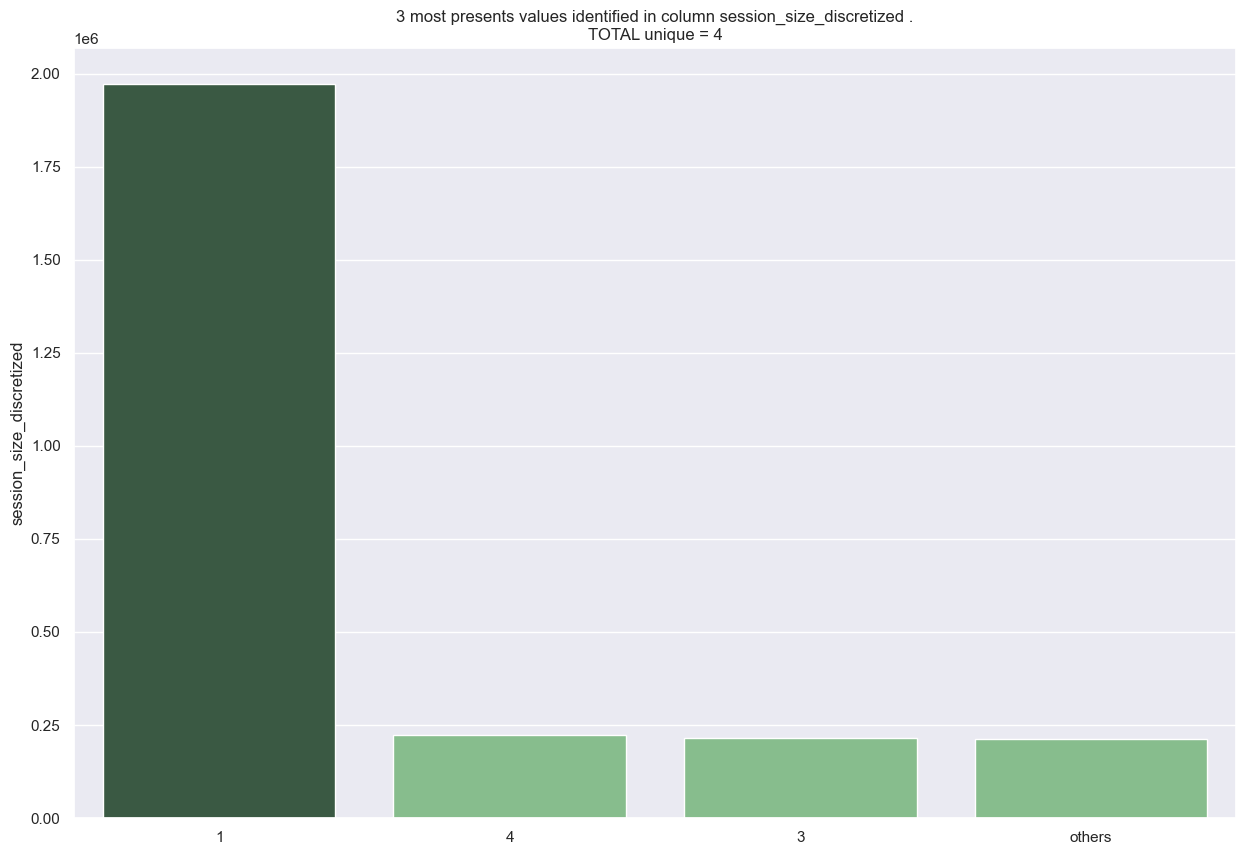

,session_size_discretized
1,1971035
4,222657
3,215573
others,212443


In [51]:
# Most articles are clicked once
df_ratio_clicks_wordscount_per_article_session['session_size_discretized'].value_counts()
plot_ntops_bar(df_ratio_clicks_wordscount_per_article_session, 'session_size_discretized', 3, True, False)

### Génération d'un Rating avancé : Utilisation de la librairie Implicit

 - [Librairie Implicit](https://implicit.readthedocs.io/en/latest/index.html)
 - [Article Towards Data Science - Approche pat Alternating Least Square (ALS) Matrix Factorization](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1)
 - [Applications of the Conjugate Gradient Method for Implicit Feedback Collaborative Filtering](https://www.semanticscholar.org/paper/Applications-of-the-conjugate-gradient-method-for-Tak%C3%A1cs-Pil%C3%A1szy/bfdf7af6cf7fd7bb5e6b6db5bbd91be11597eaf0?p2df)

### Création du modèle de recommandations : ALS et Matrix Factorisation

Nous allons ici créer les matrices qui permettront d'entrainer notre modèle de recommandations.
Pour se faire, nous allons utiliser 3 champs sur nos données d'entrainement: user_id, article_id, rating
 - Voir article [ici](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1)
 - Voir article [ici](https://towardsdatascience.com/building-a-collaborative-filtering-recommender-system-with-clickstream-data-dffc86c8c65)

In [156]:
#Repésentation visuelle de la matrice
df_clicks_ratings_train_pivot = df_clicks_ratings_train.pivot(index='user_id', columns='article_id', values='rating').fillna(0)
df_clicks_ratings_train_pivot

user_id,0,1,2,3,4,5,6,7,8,9,...,307678,307679,307680,307690,307698,307700,307721,307729,307730,307746
article_id,,,,,,,,,,,,,,,,,,,,,
1932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
# Recommender System: Alternating Least Square (ALS) Matrix Factorization in Collaborative Filtering

# Prepare matrix on training set: sparse matrix of item/user/rating
# df_clicks_ratings_train_pivot = df_clicks_ratings_train.pivot(index='article_id', columns='user_id', values='rating').fillna(0)
# sparse_user_item = scipy.sparse.csr_matrix(df_clicks_ratings_train_pivot.values)
sparse_user_item_easy = scipy.sparse.csr_matrix((df_clicks_ratings_train['rating'].astype(float),
                                                 (df_clicks_ratings_train['user_id'], 
                                                 df_clicks_ratings_train['article_id'])))

sparse_user_item_medium = scipy.sparse.csr_matrix((df_ratio_clicks_session_size_over_article_clicks_session_train['rating'].astype(float),
                                                 (df_ratio_clicks_session_size_over_article_clicks_session_train['user_id'], 
                                                 df_ratio_clicks_session_size_over_article_clicks_session_train['article_id'])))

sparse_user_item_complex = scipy.sparse.csr_matrix((df_ratio_clicks_wordscount_per_article_session_train['rating'].astype(float),
                                                 (df_ratio_clicks_wordscount_per_article_session_train['user_id'], 
                                                 df_ratio_clicks_wordscount_per_article_session_train['article_id'])))

# #Entrainement de la modélisation ALS (AlternatingLeastSquares)
model_easy = implicit.als.AlternatingLeastSquares(factors=100,iterations=200,regularization=0.1)
model_easy.fit(sparse_user_item_easy)
pickle.dump(model_easy, open(os.path.join(data_path, 'CF_model_based_easy.pkl'), 'wb'))

#Entrainement de la modélisation ALS (AlternatingLeastSquares)
model_medium = implicit.als.AlternatingLeastSquares(factors=100,iterations=200,regularization=0.1)
model_medium.fit(sparse_user_item_medium)
pickle.dump(model_medium, open(os.path.join(data_path, 'CF_model_based_medium.pkl'), 'wb'))

#Entrainement de la modélisation ALS (AlternatingLeastSquares)
model_complex = implicit.als.AlternatingLeastSquares(factors=100,iterations=200,regularization=0.1)
model_complex.fit(sparse_user_item_complex)
pickle.dump(model_complex, open(os.path.join(data_path, 'CF_model_based_complex.pkl'), 'wb'))

c:\Users\blanc\anaconda3\envs\IA_Project9\lib\site-packages\implicit\utils.py:31: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(
100%|██████████| 200/200 [02:09<00:00,  1.55it/s]


In [57]:
# Unit Test : Recommend items for a user
userid = 72

recommendations_easy = model_easy.recommend(userid, sparse_user_item_easy[userid], N=5)
print(f"Les 5 articles recommandés par le rating *Easy* sont : {recommendations_easy[0].tolist()}")

recommendations_medium = model_medium.recommend(userid, sparse_user_item_medium[userid], N=5)
print(f"Les 5 articles recommandés par le rating *Medium* sont  : {recommendations_medium[0].tolist()}")

recommendations_complex = model_complex.recommend(userid, sparse_user_item_complex[userid], N=5)
print(f"Les 5 articles recommandés par le rating *Complex* sont  : {recommendations_complex[0].tolist()}")

Les 5 articles recommandés par le rating *Easy* sont : [336499, 218330, 285719, 123826, 284410]
Les 5 articles recommandés par le rating *Medium* sont  : [284410, 218330, 123826, 108855, 156723]
Les 5 articles recommandés par le rating *Complex* sont  : [284410, 218330, 108855, 123826, 156723]


In [166]:
# E2E Test : Recommend items for all users from test set, and measure performance
user_id_serie = df_clicks_metadata_test['user_id'].unique()
k=5
score_serie = []
hit_count_serie = []
average_precision_k_serie = []
y_true_lenght_serie = []
y_pred_serie = []
y_true_serie = []

# Boucle for sur la liste des User_Id_Test, et mesure Top_k_accuracy, en utilisant les Embbeding réduit
for user in user_id_serie: #df_clicks_metadata_test['user_id'].unique()
    recommendations = model_easy.recommend(user, sparse_user_item[user], N=5)
    y_pred = recommendations[0].tolist()
    y_true = df_clicks_metadata_test.loc[df_clicks_metadata_test['user_id'] == user, 'click_article_id'].tolist()
    average_precision_k, hit_count = compute_metrics_map_hitcount(y_true, y_pred, k)
    # Append user recommendantions result in list
    hit_count_serie.append(hit_count)
    average_precision_k_serie.append(average_precision_k)
    y_true_lenght_serie.append(len(y_true))
    y_pred_serie.append(y_pred) #array_articles_embeddings_centré_réduit
    y_true_serie.append(y_true)

results_modelbased = pd.DataFrame(columns=['user_id', 'hit_count', 'average_precision', 'y_true_lenght_serie', 'y_pred_serie', 'y_true_serie'])
results_modelbased['user_id'] = user_id_serie
results_modelbased['hit_count'] = hit_count_serie
results_modelbased['average_precision'] = average_precision_k_serie
results_modelbased['y_true_lenght_serie'] = y_true_lenght_serie
results_modelbased['y_pred_serie'] = y_pred_serie
results_modelbased['y_true_serie'] = y_true_serie

Mean_Average_Precision_at_k = results_modelbased['average_precision'].mean() #np.mean([average_precision_k(y_true, y_pred, k=5) for y_true, y_pred in zip(y_true_serie, y_pred_serie)])
print(f"Mean_Average_Precision_at_k is = {Mean_Average_Precision_at_k}")
results_modelbased.to_csv(os.path.join(data_path, "results_modelbased_ALS_full.csv"))
results_modelbased.sort_values('average_precision', ascending=False).head()

,user_id,hit_count,average_precision,y_true_lenght_serie,y_pred_serie,y_true_serie
1251,283860,1.0,0.5,2,"[293513, 288440, 283505, 284583, 236610]","[293513, 10614]"
42960,178420,1.0,0.5,2,"[63307, 31520, 124228, 276970, 64409]","[63307, 115301]"
365,265109,1.0,0.5,1,"[270607, 245161, 158882, 285377, 50504]",[245161]
6053,307494,1.0,0.5,2,"[293513, 288440, 284463, 270607, 337143]","[293513, 293514]"
8282,306120,1.0,0.5,2,"[293513, 270607, 348112, 288440, 285377]","[70217, 293513]"


In [164]:
results_modelbased['hit_count'].sum() / results_modelbased['hit_count'].count()


0.0013789043133366386

In [165]:
results_modelbased['hit_count'].mean()

0.0013789043133366386

In [ ]:
# predict sur le train
# mesure Top_k_accuracy sur le test

### Méthod KNN

In [39]:
# Pivot ratings 'clicked_article' into 'category_id'/'user_id' matrix
df_clicks_ratings_train_pivot = df_clicks_ratings_train.pivot(index='category_id', columns='user_id', values='clicked_article').fillna(0)

# convert 'category_id'/'user_id' matrix to scipy sparse matrix
matrix_category_id_features = scipy.sparse.csr_matrix(df_clicks_ratings_train_pivot.values)

num_users = len(df_clicks_ratings_train['user_id'].unique())
num_categories = len(df_clicks_ratings_train['category_id'].unique())
print('There are {} unique users and {} unique article category in this Training DataSet'.format(num_users, num_categories))
df_clicks_ratings_train_pivot.head()

There are 189124 unique users and 158 unique article category in this Training DataSet


user_id,0,1,2,3,4,5,6,7,8,9,...,295797,295818,295828,295831,295832,295843,295849,295852,295853,295854
category_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(matrix_category_id_features)

distances, indices = model_knn.kneighbors(matrix_category_id_features[26], n_neighbors=5+1)
print(distances)
print(indices)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [72]:
# from surprise import KNNWithMeans

# # To use item-based cosine similarity
# sim_options = {
#     "name": "cosine",
#     "user_based": False,  # Compute  similarities between items
# }
# algo = KNNWithMeans(sim_options=sim_options)
# algo.fit(trainset)
# prediction = algo.predict(72, 285412)


Computing the cosine similarity matrix...
Done computing similarity matrix.


[[0.         0.68693582 0.69307385 0.71293126 0.71534827 0.71568595]]
[[ 26 116 149 137  99 139]]


In [24]:
# With train_test_split not secured (using function from sickit surprise)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5)) #default rating_scaale is (2, 5) - rating_scale=(1, 5)
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_clicks_ratings[['user_id', 'category_id', 'clicked_article']], reader)
# Splitting our dataset in train and test set in a ratio of 75%:25%
trainset, testset = train_test_split(data, test_size=0.25)
# SVD is a Matrix Factorization techniques 
algo = SVD()
# Train the model
algo.fit(trainset)
# predict on the test set
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 1.6763


1.6762969532751222

In [25]:
# With train_test_split secured (using pre-splitted dataset)

#Check doc here: https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset
#Check example here: https://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5)) #default rating_scaale is (2, 5) - rating_scale=(1, 5)
# Load the train and test data # The columns must correspond to user id, item id and ratings (in that order).
train_data = Dataset.load_from_df(df_clicks_ratings_train[['user_id', 'category_id', 'clicked_article']], reader)
test_data = Dataset.load_from_df(df_clicks_ratings_test[['user_id', 'category_id', 'clicked_article']], reader)

# SVD is a Matrix Factorization techniques 
algo = SVD()
# Train the model
algo.fit(train_data)
# predict on the test set
predictions = algo.test(test_data)
accuracy.rmse(predictions)

AttributeError: 'DatasetAutoFolds' object has no attribute 'n_users'

In [40]:

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5)) #default rating_scaale is (2, 5)
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_clicks_ratings[['user_id', 'category_id', 'clicked_article']], reader)
# We can now use this dataset as we please, e.g. calling cross_validate
cross_validate(NormalPredictor(), data, cv=2)

{'test_rmse': array([2.24527069, 2.20301793]),
 'test_mae': array([1.28092439, 1.2948972 ]),
 'fit_time': (1.0536212921142578, 1.645843267440796),
 'test_time': (5.710712432861328, 6.466669082641602)}

In [32]:
# Load the train and test data
# The columns must correspond to user id, item id and ratings (in that order).
train_data = Dataset.load_from_df(df_clicks_ratings_train[['user_id', 'category_id', 'clicked_article']], reader)
test_data = Dataset.load_from_df(df_clicks_ratings_test[['user_id', 'category_id', 'clicked_article']], reader)

folds_files = [train_data, test_data]
data = Dataset.load_from_folds(folds_files, reader=reader)

pkf = PredefinedKFold()

algo = SVD()
# train and test algorithm.
algo.fit(train_data)
predictions = algo.test(test_data)

# Compute and print Root Mean Squared Error
accuracy.rmse(predictions, verbose=True)

TypeError: 'DatasetAutoFolds' object is not iterable

## Methode KNN

<158x189124 sparse matrix of type '<class 'numpy.float64'>'
	with 1363435 stored elements in Compressed Sparse Row format>

In [ ]:
def make_recommendations(self, clicked_article, n_recommendations = 5):
    """
    Build top n articles recommendations
    Parameters
    ----------
    clicked_article: str, name of user clicked article
    n_recommendations: int, top n recommendations
    """
    # get data
    movie_user_mat_sparse, hashmap = self._prep_data()
    # get recommendations
    raw_recommends = self._inference(
        self.model, movie_user_mat_sparse, hashmap,
        fav_movie, n_recommendations)
    # print results
    reverse_hashmap = {v: k for k, v in hashmap.items()}
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance '
              'of {2}'.format(i+1, reverse_hashmap[idx], dist))

In [ ]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations = 5):
    """
    Return
    ------
    list of top n similar article recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    #idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))


make_recommendation(model_knn=model_knn,    
                    data=matrix_category_id_features,
                    fav_movie=my_favorite,
                    mapper=movie_to_idx,
                    n_recommendations=10
                    )

## Collaborative filtering : Approche pat Alternating Least Square (ALS) Matrix Factorization
[Voir Article towards data science](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1)

c:\Users\blanc\anaconda3\envs\IA_Project9\lib\site-packages\implicit\utils.py:31: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(
100%|██████████| 200/200 [01:26<00:00,  2.33it/s]


In [58]:
# calcuate total number of entries in the movie-user matrix
num_entries = df_clicks_ratings_train_pivot.shape[0] * df_clicks_ratings_train_pivot.shape[1]
# calculate total number of entries with zero values
num_zeros = (df_clicks_ratings_train_pivot==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of missing ratings'.format(ratio_zeros))

There is about 95.44% of missing ratings


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)